#**CUADERNO- TFM DEFAULT BANCARIO**
### **ANÁLISIS EXPLORATORIO Y LIMPIEZA Y TRATAMIENTO DE DATOS**
Realizado por:
- Eva Meneses Soto, emenesess@student.eae.es
- Ana María Quintero Estevez, aquinteroe@student.eae.es
- María Regina Meiners de Alba, mmeinersd@student.eae.es

### **Cargarmos las librerias y el drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files


!pip install pandas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.ticker import MaxNLocator

!pip install scipy
import scipy
from scipy.stats import norm
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

!pip install ydata-profiling
import ydata_profiling as tools
from ydata_profiling import ProfileReport

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Cargamos el fichero**

In [ ]:
loan = pd.read_csv("/content/drive/My Drive/TFM/LoanDataset.csv", nrows = 100000)

#### Creamos un estilo que posteriormente utilizaremos para la creación de las tablas

In [ ]:
header_style = {
    'selector': 'th',
    'props': [
        ('background-color', '#C6D9F1'),
        ('font-weight', 'bold'),
        ('font-family', 'Times New Roman'),
        ('font-size', '14px'),
        ('text-align', 'center')
    ]
}

cell_style = {
    'selector': 'td',
    'props': [
        ('font-family', 'Times New Roman'),
        ('font-size', '12px'),
        ('text-align', 'center')
    ]
}

### **Lectura del dataset**

Imprimimos las variables del dataset con el conteo y el tipo de variable

In [ ]:
info_df = pd.DataFrame({
    'Column': loan.columns,
    'Non-Null Count': loan.notnull().sum(),
    'Dtype': loan.dtypes.astype(str)
}).reset_index(drop=True)

styled_info = info_df.style.set_table_styles([header_style, cell_style])
display(styled_info)

,Column,Non-Null Count,Dtype
0,customer_id,32583,float64
1,customer_age,32586,int64
2,customer_income,32586,object
3,home_ownership,32586,object
4,employment_duration,31691,float64
5,loan_intent,32586,object
6,loan_grade,32586,object
7,loan_amnt,32585,object
8,loan_int_rate,29470,float64
9,term_years,32586,int64


Imprimimos las dimensiones de Dataset

In [ ]:
shape_df = pd.DataFrame({
    ' ': ['Número de Filas', 'Número de Columnas'],
    '   ': [loan.shape[0], loan.shape[1]]
})

styled_shape = shape_df.style.set_table_styles([header_style, cell_style])
display(styled_shape)

,,
0,Número de Filas,32586
1,Número de Columnas,13


Realizamos una descripción del dataset

In [ ]:
styled_loan_describe = loan.describe().T.style.format("{:.2f}").set_table_styles([header_style, cell_style])
display(styled_loan_describe)

,count,mean,std,min,25%,50%,75%,max
customer_id,32583.00,16289.50,9405.92,1.00,8144.50,16288.00,24433.50,32581.00
customer_age,32586.00,27.73,6.36,3.00,23.00,26.00,30.00,144.00
employment_duration,31691.00,4.79,4.14,0.00,2.00,4.00,7.00,123.00
loan_int_rate,29470.00,11.01,3.24,5.42,7.90,10.99,13.47,23.22
term_years,32586.00,4.76,2.47,1.00,3.00,4.00,7.00,10.00
cred_hist_length,32586.00,5.80,4.06,2.00,3.00,4.00,8.00,30.00


In [ ]:
#Cambiamos los tipos de variables a los correctos
loan[['customer_id', 'employment_duration']] = loan[['customer_id', 'employment_duration']].astype('Int64')
loan[['home_ownership', 'loan_intent', 'loan_grade']] = loan[['home_ownership', 'loan_intent', 'loan_grade']].astype('string')

#En el caso de customer income existen algunos datos que se ingresaron con coma por lo que la eliminamos antes de convertir a numeros enteros
loan['customer_income'] = loan['customer_income'].astype(str).str.replace(',', '', regex=False).astype('Int64')

#Quitamos la moneda del monto de los préstamos para que se tomen como monto y no como texto £
loan['loan_amnt'] = loan['loan_amnt'].astype(str).str.replace('¬', '', regex=False).str.replace('£', '', regex=False).str.replace(',', '', regex=False).astype(float)

#Convertimos la variable target y la de historical default a booleanas.
loan['historical_default'] = loan['historical_default'].map({'Y': True, 'N': False}).astype('boolean')
loan['Current_loan_status'] = loan['Current_loan_status'].map({'DEFAULT': True, 'NO DEFAULT': False}).astype('boolean')

In [ ]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32586 entries, 0 to 32585
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          32583 non-null  Int64  
 1   customer_age         32586 non-null  int64  
 2   customer_income      32586 non-null  Int64  
 3   home_ownership       32586 non-null  string 
 4   employment_duration  31691 non-null  Int64  
 5   loan_intent          32586 non-null  string 
 6   loan_grade           32586 non-null  string 
 7   loan_amnt            32585 non-null  float64
 8   loan_int_rate        29470 non-null  float64
 9   term_years           32586 non-null  int64  
 10  historical_default   11849 non-null  boolean
 11  cred_hist_length     32586 non-null  int64  
 12  Current_loan_status  32582 non-null  boolean
dtypes: Int64(3), boolean(2), float64(2), int64(3), string(3)
memory usage: 3.0 MB


In [ ]:
loan.head()

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
0,1,22,59000,RENT,123,PERSONAL,C,35000.0,16.02,10,True,3,True
1,2,21,9600,OWN,5,EDUCATION,A,1000.0,11.14,1,<NA>,2,False
2,3,25,9600,MORTGAGE,1,MEDICAL,B,5500.0,12.87,5,False,3,True
3,4,23,65500,RENT,4,MEDICAL,B,35000.0,15.23,10,False,2,True
4,5,24,54400,RENT,8,MEDICAL,B,35000.0,14.27,10,True,4,True


In [ ]:
loan.tail()

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
32581,32577,57,53000,MORTGAGE,1,PERSONAL,C,5800.0,13.16,7,<NA>,30,False
32582,32578,54,120000,MORTGAGE,4,PERSONAL,A,17625.0,7.49,4,<NA>,19,False
32583,32579,65,76000,RENT,3,HOMEIMPROVEMENT,B,35000.0,10.99,5,False,28,True
32584,32580,56,150000,MORTGAGE,5,PERSONAL,B,15000.0,11.48,6,<NA>,26,False
32585,32581,99,42000,RENT,2,MEDICAL,B,6475.0,9.99,6,<NA>,30,False


Vemos si exiten valores nulos

In [ ]:
styled_nulls = loan.isnull().sum().reset_index()
styled_nulls.columns = ['Columna', 'Cantidad de nulos']

styled_nulls_table = styled_nulls.style.set_table_styles([header_style, cell_style])
display(styled_nulls_table)

,Columna,Cantidad de nulos
0,customer_id,3
1,customer_age,0
2,customer_income,0
3,home_ownership,0
4,employment_duration,895
5,loan_intent,0
6,loan_grade,0
7,loan_amnt,1
8,loan_int_rate,3116
9,term_years,0


Vemos que tan desbalanceada está la variable target, vemos que es moderadamente desbalanceada

In [ ]:
current_loan_status_percent = loan['Current_loan_status'].value_counts(normalize=True) * 100
current_loan_status_percent = current_loan_status_percent.reset_index()
current_loan_status_percent.columns = ['Current_loan_status', 'Porcentaje']

styled_current_loan_status = current_loan_status_percent.style.set_table_styles([header_style, cell_style]).format({'Porcentaje': '{:.2f}%'})
display(styled_current_loan_status)

,Current_loan_status,Porcentaje
0,False,79.01%
1,True,20.99%


#**ANÁLISIS EXPLORATORIO DE DATOS**

Antes de empezar, creamos un EDA automatico

In [ ]:
#profile = ProfileReport(loan, title="EDA Report", explorative=True)
#profile.to_file("eda_report.html")
#profile.to_file("eda_report.html")

In [ ]:
#Descargar este archivo
#files.download("eda_report.html")

## **ANÁLISIS UNIVARIANTE**

#### **VARIABLES NUMÉRICAS**

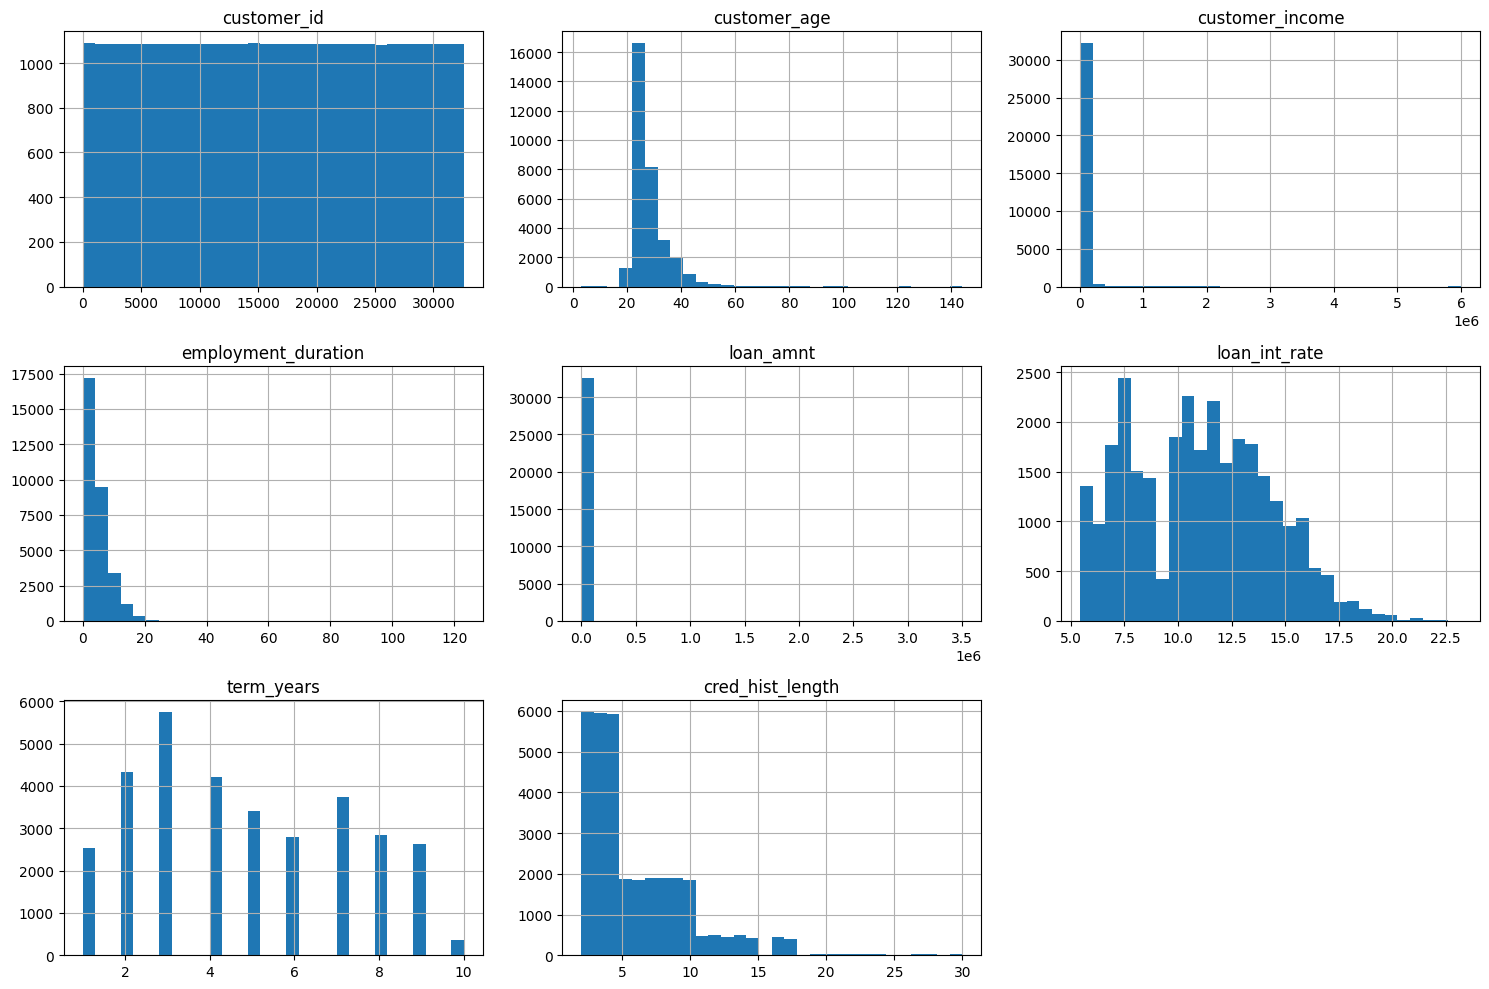

In [ ]:
loan.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

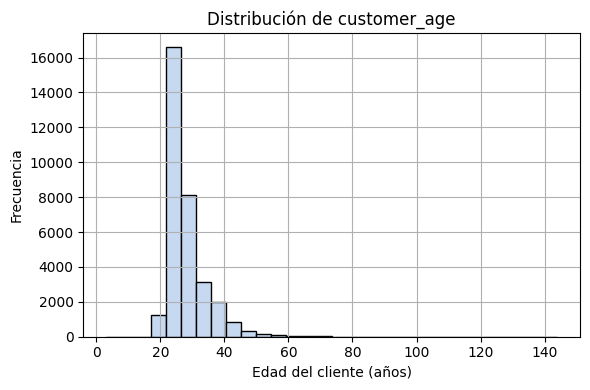

In [ ]:
# Histograma para customer_age
plt.figure(figsize=(6, 4))
loan['customer_age'].hist(bins=30, color='#C6D9F1', edgecolor='black')
plt.title('Distribución de customer_age')
plt.xlabel('Edad del cliente (años)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

In [ ]:
Desviación estandar de la edad del cliente

customer_age_std = loan['customer_age'].std()
print(f"La desviación estándar de la edad del cliente es: {customer_age_std:.2f}")

La desviación estándar de la edad del cliente es: 6.36


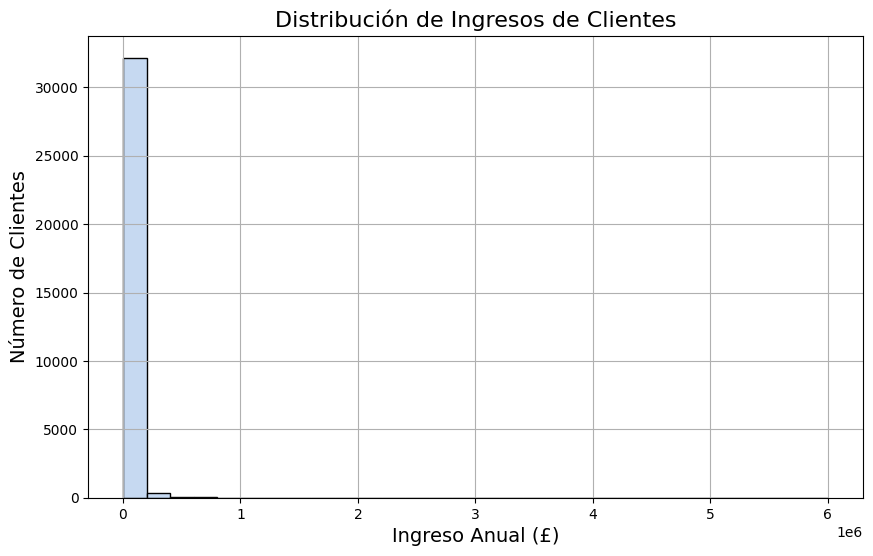

In [ ]:
# Distribución de los ingresos de Clientes
plt.figure(figsize=(10,6))
plt.hist(loan['customer_income'], bins=30, color='#c6d9f1', edgecolor='black')
plt.title('Distribución de Ingresos de Clientes', fontsize=16)
plt.xlabel('Ingreso Anual (£)', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
plt.grid(True)
plt.show()

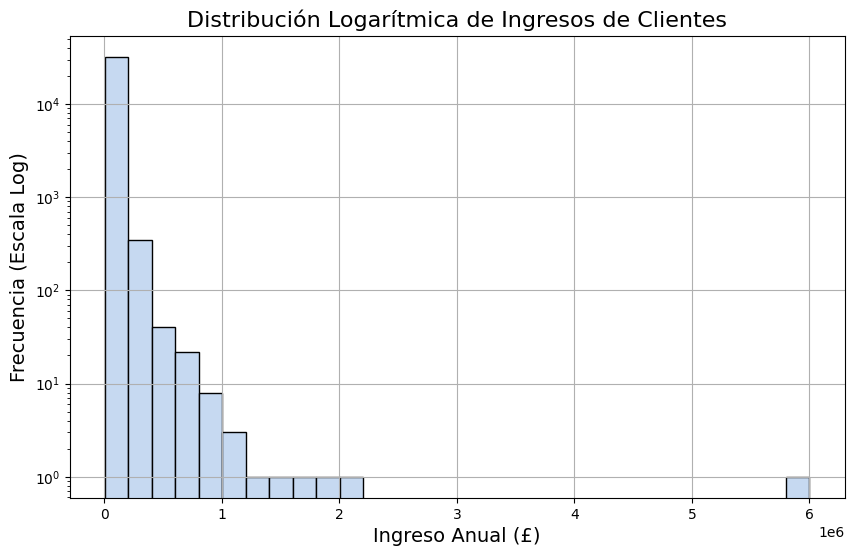

In [ ]:
# Distribución de los ingresos de los clientes logarítmica
plt.figure(figsize=(10,6))
plt.hist(loan['customer_income'], bins=30, color='#c6d9f1', edgecolor='black', log=True)
plt.title('Distribución Logarítmica de Ingresos de Clientes', fontsize=16)
plt.xlabel('Ingreso Anual (£)', fontsize=14)
plt.ylabel('Frecuencia (Escala Log)', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# Desviación estándar del ingreso anual
customer_income_std = loan['customer_income'].std()
print(f"La desviación estándar del ingreso anual del cliente es: £{customer_income_std:.2f}")

La desviación estándar del ingreso anual del cliente es: £61980.29


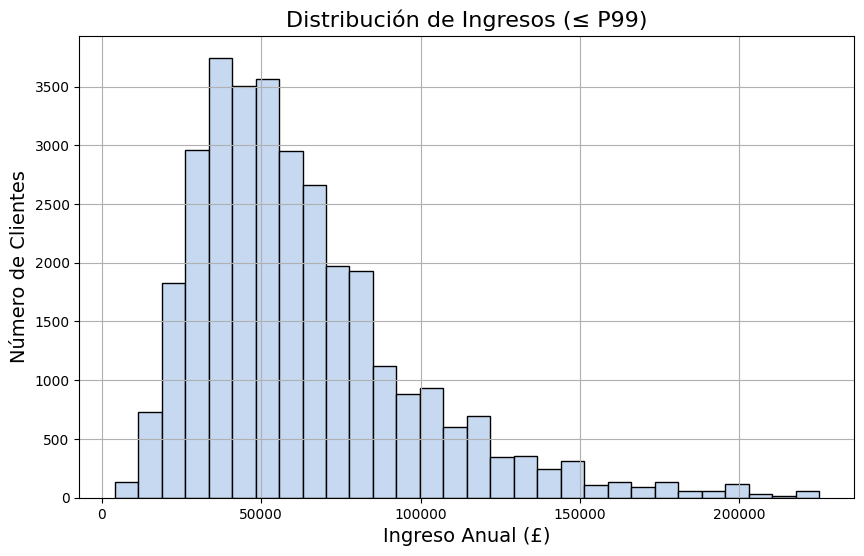

In [ ]:
## Distribución de los ingresos de los clientes percentil 99
income_p99 = loan['customer_income'].quantile(0.99)
income_filtered = loan[loan['customer_income'] <= income_p99]['customer_income']

plt.figure(figsize=(10,6))
plt.hist(income_filtered, bins=30, color='#c6d9f1', edgecolor='black')
plt.title('Distribución de Ingresos (≤ P99)', fontsize=16)
plt.xlabel('Ingreso Anual (£)', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
plt.grid(True)
plt.show()

<ipython-input-20-111865011>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


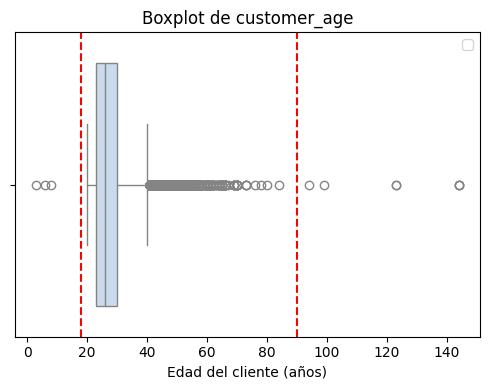

In [ ]:
## Boxplot de customer_age
plt.figure(figsize=(5, 4))
sns.boxplot(x=loan['customer_age'], color='#C6D9F1')

# Línea vertical en 90 años mostrando y en los 18 para observar los outlair de mejor manera
plt.axvline(x=90, color='red', linestyle='--', linewidth=1.5)
plt.axvline(x=18, color='red', linestyle='--', linewidth=1.5)

plt.title('Boxplot de customer_age')
plt.xlabel('Edad del cliente (años)')
plt.legend()
plt.tight_layout()
plt.show()

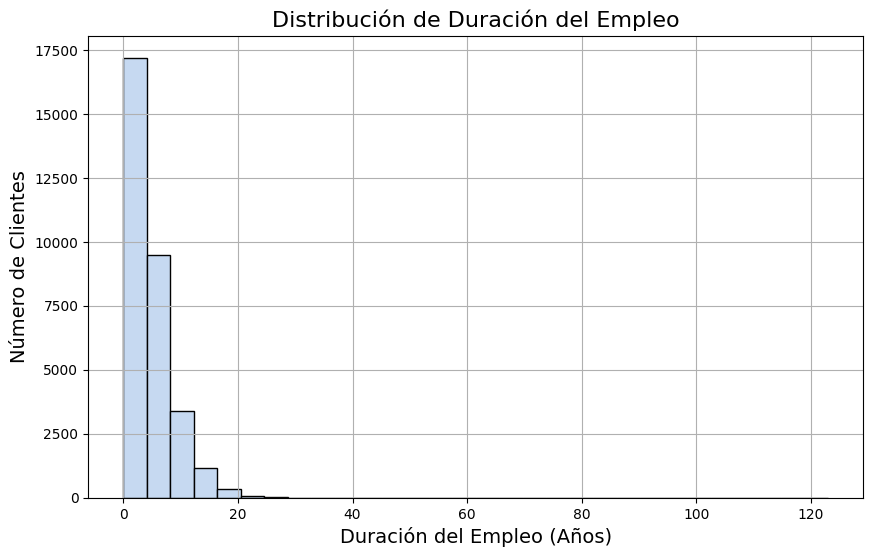

In [ ]:
## Distribución de la duración del empleo
plt.figure(figsize=(10,6))
plt.hist(loan['employment_duration'], bins=30, color='#c6d9f1', edgecolor='black')
plt.title('Distribución de Duración del Empleo', fontsize=16)
plt.xlabel('Duración del Empleo (Años)', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
plt.grid(True)
plt.show()

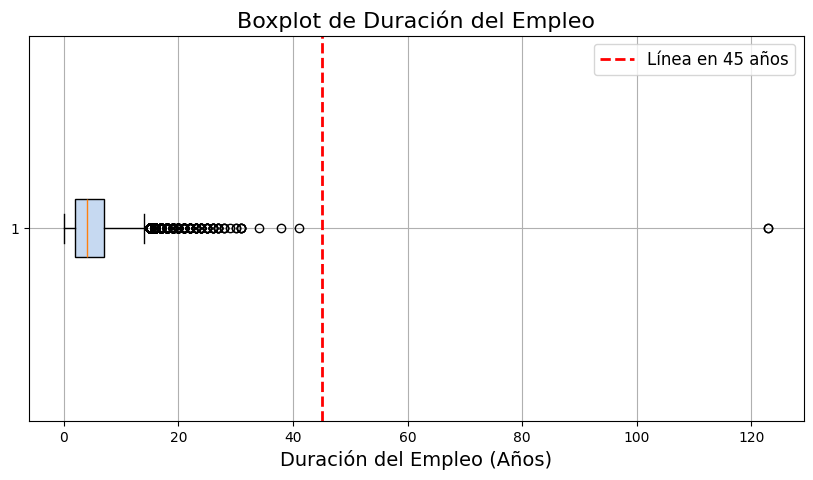

In [ ]:
## Boxplot de la duración del empleo
plt.figure(figsize=(10,5))
plt.boxplot(loan['employment_duration'].dropna(), patch_artist=True, boxprops=dict(facecolor='#c6d9f1'), vert=False)
plt.title('Boxplot de Duración del Empleo', fontsize=16)
plt.xlabel('Duración del Empleo (Años)', fontsize=14)
plt.axvline(x=45, color='red', linestyle='--', linewidth=2, label='Línea en 45 años')  # Añadimos linea
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

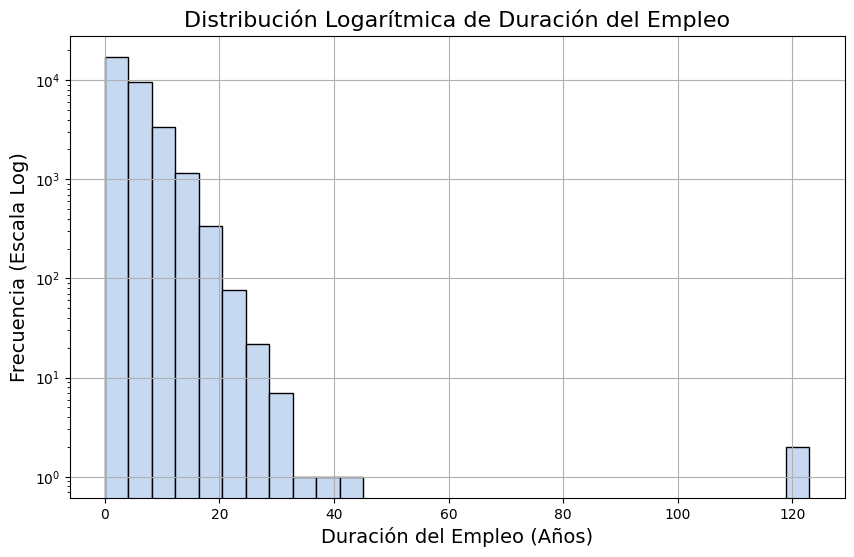

In [ ]:
## Distribución Logaritmica de la duración del empleo
plt.figure(figsize=(10,6))
plt.hist(loan['employment_duration'], bins=30, color='#c6d9f1', edgecolor='black', log=True)
plt.title('Distribución Logarítmica de Duración del Empleo', fontsize=16)
plt.xlabel('Duración del Empleo (Años)', fontsize=14)
plt.ylabel('Frecuencia (Escala Log)', fontsize=14)
plt.grid(True)
plt.show()

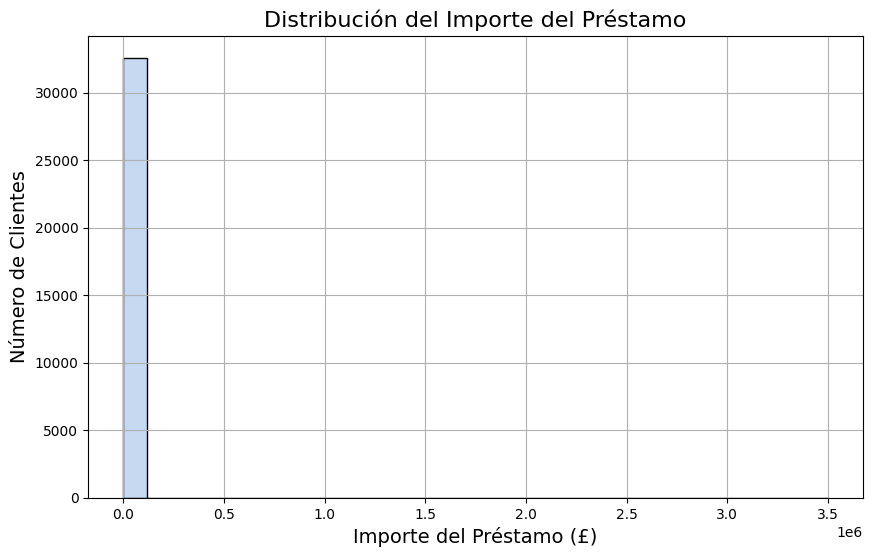

In [ ]:
## Distribución del Importe del Préstamo
plt.figure(figsize=(10,6))
plt.hist(loan['loan_amnt'].dropna(), bins=30, color='#c6d9f1', edgecolor='black')
plt.title('Distribución del Importe del Préstamo', fontsize=16)
plt.xlabel('Importe del Préstamo (£)', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
plt.grid(True)
plt.show()

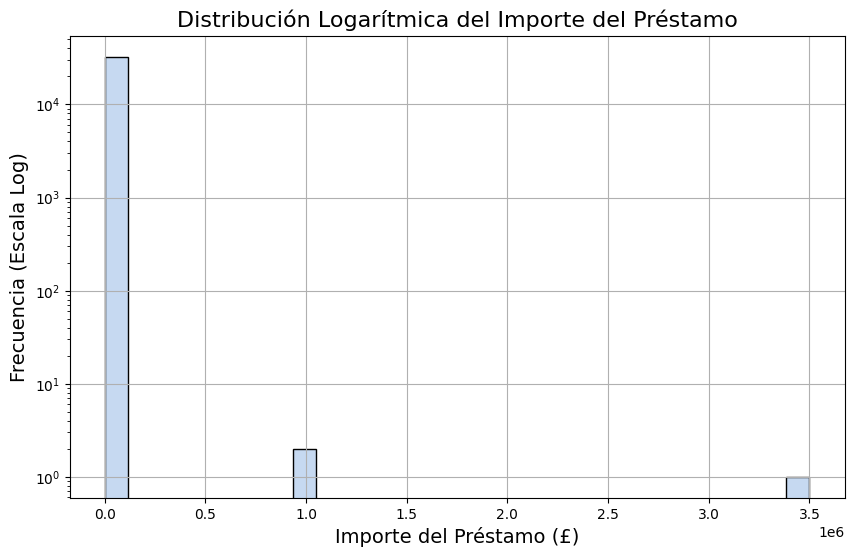

In [ ]:
## Distribución logaritmica del Importe del Préstamo
plt.figure(figsize=(10,6))
plt.hist(loan['loan_amnt'].dropna(), bins=30, color='#c6d9f1', edgecolor='black', log=True)
plt.title('Distribución Logarítmica del Importe del Préstamo', fontsize=16)
plt.xlabel('Importe del Préstamo (£)', fontsize=14)
plt.ylabel('Frecuencia (Escala Log)', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
## Percentil 99 del Importe del Préstamo
percentil_99 = loan['loan_amnt'].dropna().quantile(0.99)
print(f"Percentil 99 de loan_amnt: {percentil_99:.2f} £")

Percentil 99 de loan_amnt: 29808.00 £


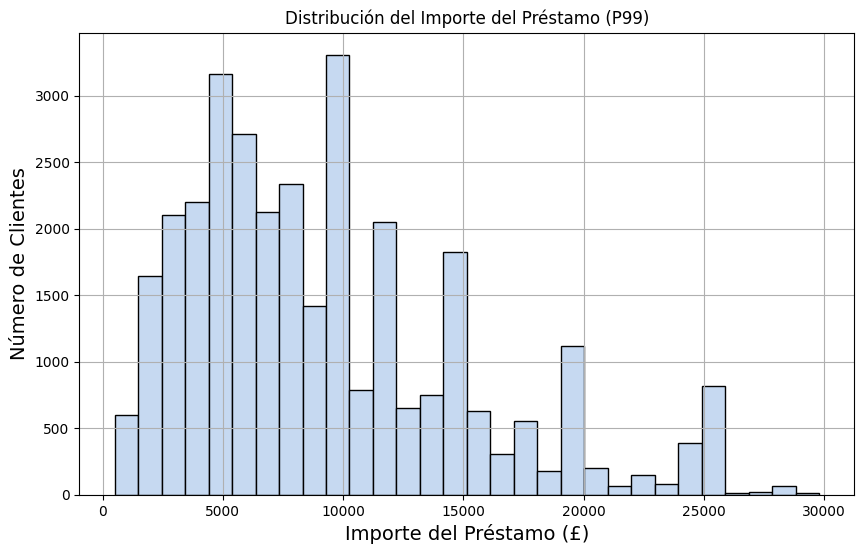

In [ ]:
## Distribución per99 del Importe del préstamo
loan_amnt_limpio = loan[loan['loan_amnt'] <= percentil_99]['loan_amnt']
plt.figure(figsize=(10,6))

plt.hist(loan_amnt_limpio, bins=30, color='#c6d9f1', edgecolor='black')
plt.title('Distribución del Importe del Préstamo (P99)')
plt.xlabel('Importe del Préstamo (£)', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
plt.grid(True)
plt.show()

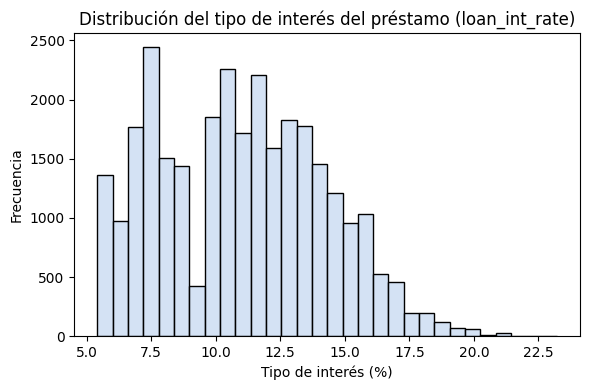

In [ ]:
## Distribución del tipo de Interés del préstamo
plt.figure(figsize=(6, 4))
sns.histplot(loan['loan_int_rate'], bins=30, color='#C6D9F1', edgecolor='black')
plt.title('Distribución del tipo de interés del préstamo (loan_int_rate)')
plt.xlabel('Tipo de interés (%)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

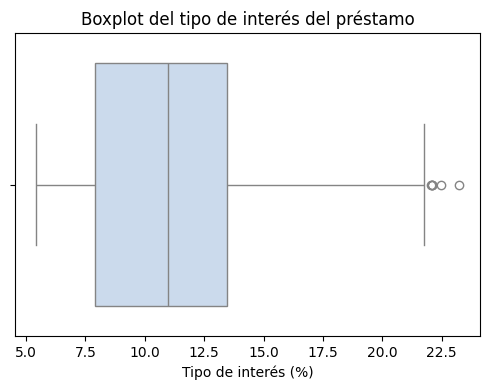

In [ ]:
## Boxplot del tipo de interés del préstamo
plt.figure(figsize=(5, 4))
sns.boxplot(x=loan['loan_int_rate'], color='#C6D9F1')
plt.title('Boxplot del tipo de interés del préstamo')
plt.xlabel('Tipo de interés (%)')
plt.tight_layout()
plt.show()

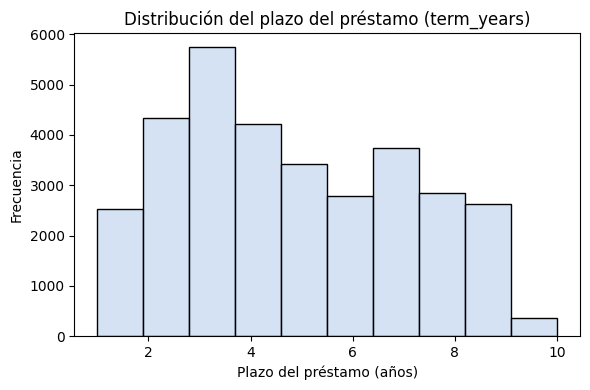

In [ ]:
# Histograma del plazo del préstamo
plt.figure(figsize=(6, 4))
sns.histplot(loan['term_years'], bins=10, color='#C6D9F1', edgecolor='black')
plt.title('Distribución del plazo del préstamo (term_years)')
plt.xlabel('Plazo del préstamo (años)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()



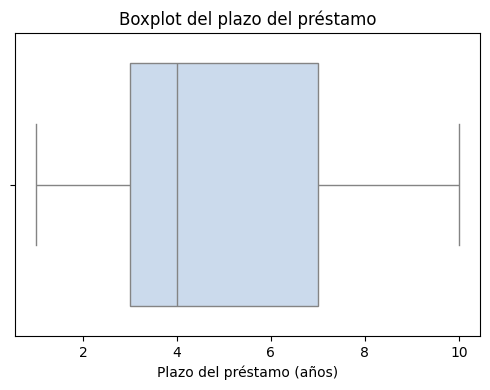

In [ ]:
# Boxplot del plazo del préstamo
plt.figure(figsize=(5, 4))
sns.boxplot(x=loan['term_years'], color='#C6D9F1')
plt.title('Boxplot del plazo del préstamo')
plt.xlabel('Plazo del préstamo (años)')
plt.tight_layout()
plt.show()

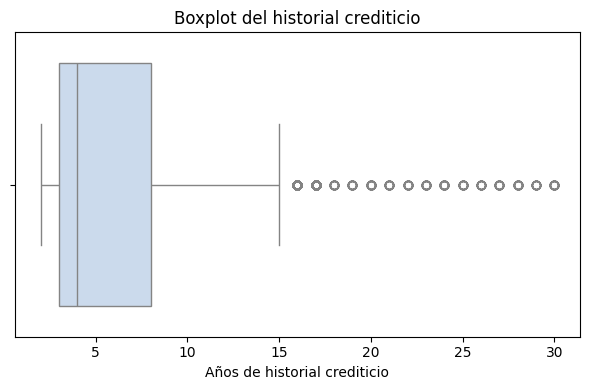

In [ ]:
## Boxplot del historial crediticio
plt.figure(figsize=(6, 4))
sns.boxplot(x=loan['cred_hist_length'], color='#C6D9F1')
plt.title('Boxplot del historial crediticio')
plt.xlabel('Años de historial crediticio')
plt.tight_layout()
plt.show()

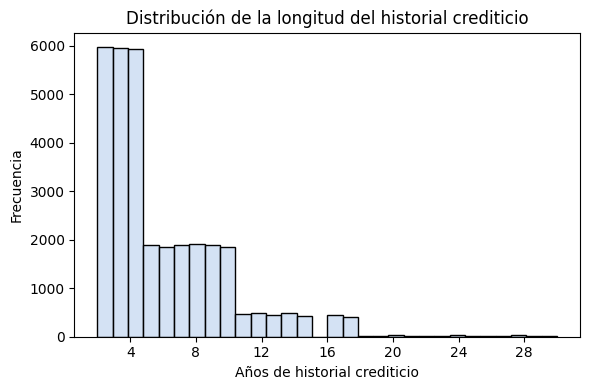

In [ ]:
## Distribución de historial crediticio
plt.figure(figsize=(6, 4))
ax = sns.histplot(loan['cred_hist_length'], bins=30, color='#C6D9F1', edgecolor='black')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Distribución de la longitud del historial crediticio')
plt.xlabel('Años de historial crediticio')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

#### **VARIABLES CATEGÓRICAS**

In [ ]:
# Lista de variables categóricas
cat_cols = ['home_ownership', 'loan_intent', 'loan_grade', 'historical_default', 'Current_loan_status']

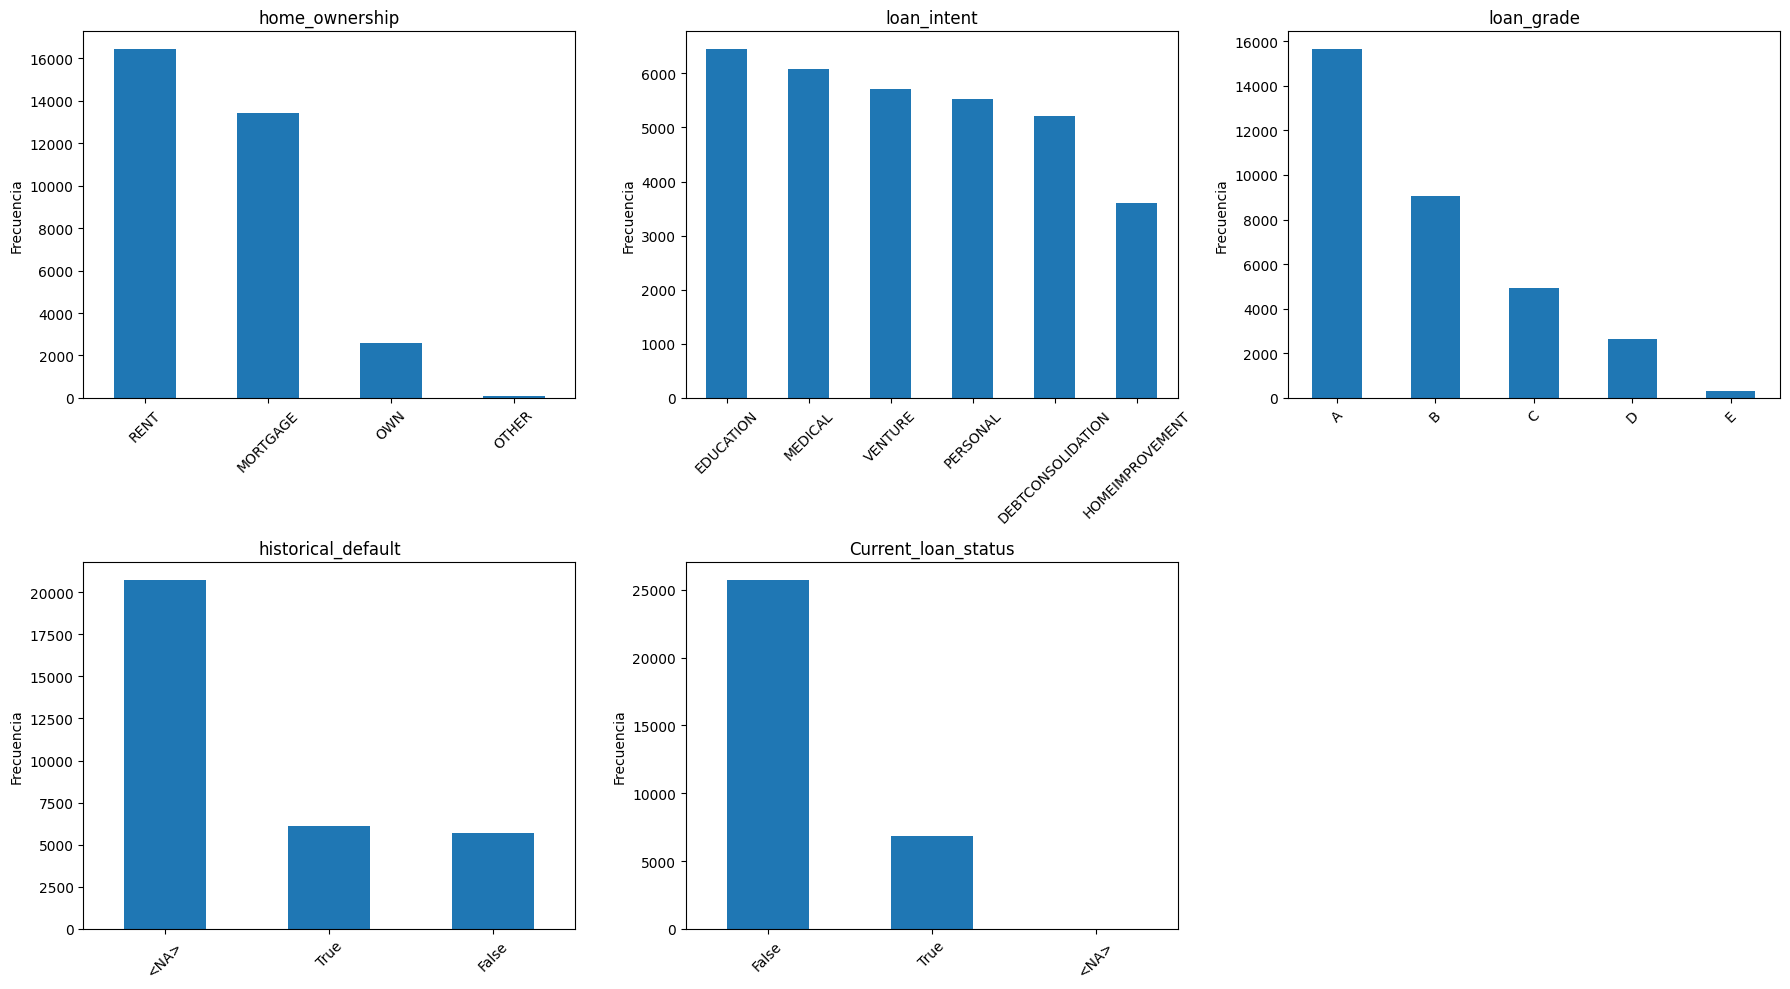

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()
for i, col in enumerate(cat_cols):
    if loan[col].dtype == 'boolean':
        values = loan[col].astype(str).fillna('Missing').replace({'True': 'True', 'False': 'False'}).value_counts()
    else:
        values = loan[col].fillna('Missing').value_counts()

    values.plot(kind='bar', ax=axs[i])
    axs[i].set_title(col)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Frecuencia')
    axs[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

<ipython-input-36-2338379869>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


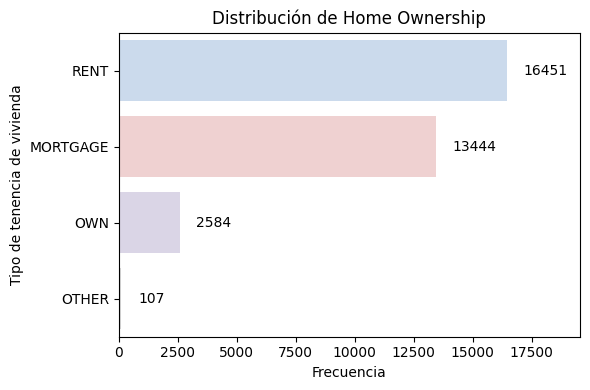

In [ ]:
## Distribución de Home Ownership

# Definimos el orden de los valores según la frecuencia
unique_vals = loan['home_ownership'].value_counts().index.tolist()

# Añadimos una paleta de colores
palette_dict = {
    'RENT': '#c6d9f1',         # azul pastel
    'MORTGAGE': '#f4cccc',     # rosa pastel
    'OWN': '#d9d2e9',          # morado pastel
    'OTHER': '#d9d9d9'         # gris pastel
}

# Creamos el gráfico
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    y='home_ownership',
    data=loan,
    order=unique_vals,
    palette=palette_dict
)

plt.xlim(0, 19550)
plt.title('Distribución de Home Ownership')
plt.xlabel('Frecuencia')
plt.ylabel('Tipo de tenencia de vivienda')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=12)

plt.tight_layout()
plt.show()


<ipython-input-37-1546446150>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='loan_intent', data=loan, order=order, palette=['#C6D9F1', '#FADADD', '#D8BFD8', '#D3D3D3', '#FFDDC1', '#B0E0E6'])


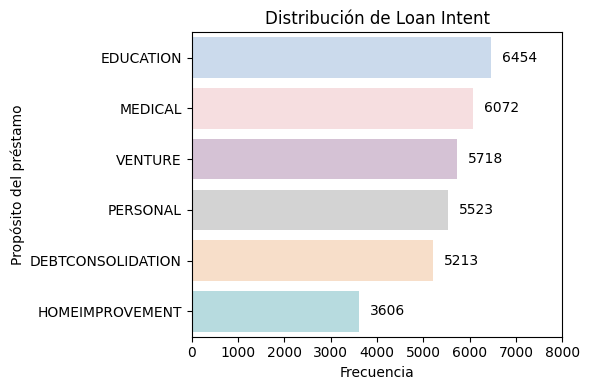

In [ ]:
## Distribución de Loan_Intent
order = loan['loan_intent'].value_counts().index

plt.figure(figsize=(6, 4))
ax = sns.countplot(y='loan_intent', data=loan, order=order, palette=['#C6D9F1', '#FADADD', '#D8BFD8', '#D3D3D3', '#FFDDC1', '#B0E0E6'])
plt.title('Distribución de Loan Intent')
plt.xlabel('Frecuencia')
plt.ylabel('Propósito del préstamo')
plt.xlim(0, 8000)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=8)

plt.subplots_adjust(right=0.85)
plt.tight_layout()
plt.show()

<ipython-input-38-288902178>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='loan_grade', data=loan, order=loan_grade_order, palette=grade_palette)


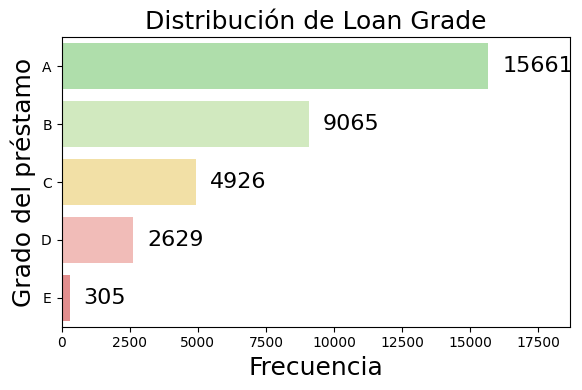

In [ ]:
## Distribución de Loan_grade
loan_grade_order = loan['loan_grade'].value_counts().sort_values(ascending=False).index

# Definimos una paleta de colores que vaya de verde (A) a rojo (E)
grade_palette = {
    'A': '#a8e6a3',  # verde pastel
    'B': '#d0f0b8',  # verde-amarillo claro
    'C': '#ffe699',  # amarillo pastel
    'D': '#fbb4ae',  # rosa pastel
    'E': '#f08080'   # rojo claro
}

# Creamos el gráfico de barras horizontal
plt.figure(figsize=(6, 4))
ax = sns.countplot(y='loan_grade', data=loan, order=loan_grade_order, palette=grade_palette)

plt.title('Distribución de Loan Grade', fontsize=18 )
plt.xlabel('Frecuencia',  fontsize=18)
plt.ylabel('Grado del préstamo',  fontsize=18)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=10, fontsize=16)

plt.xlim(0, loan['loan_grade'].value_counts().max() + 3000)
plt.tight_layout()
plt.show()

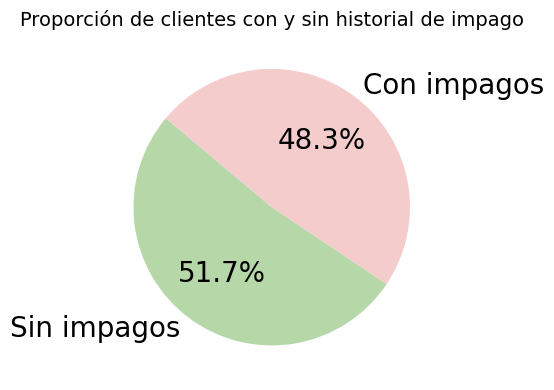

In [ ]:
## Distribución de historical_default
hist_default_counts = loan['historical_default'].value_counts()
labels = ['Sin impagos', 'Con impagos']
colors = ['#b6d7a8', '#f4cccc']  # verde pastel y rojo pastel

# Creamos el gráfico
plt.figure(figsize=(6, 4))
plt.pie(
    hist_default_counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 20}
)
plt.title('Proporción de clientes con y sin historial de impago', fontsize=14)
plt.tight_layout()
plt.show()


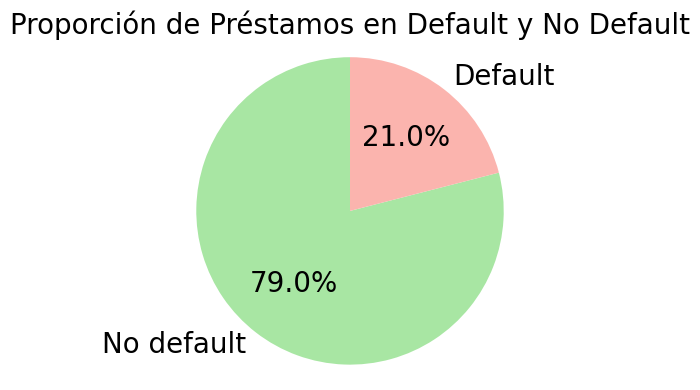

In [ ]:
## Distribución de la variable objetivo current_loan_status
status_counts = loan['Current_loan_status'].value_counts()
labels = ['No default', 'Default']
colors = ['#a8e6a3', '#fbb4ae']  # verde pastel y rosa pastel

# Creamos gráfico circular
plt.figure(figsize=(6,4))
plt.pie(status_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 20})
plt.title('Proporción de Préstamos en Default y No Default', fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

##**ANÁLISIS BIVARIANTE**

### LIMPIEZA DE LOS DATOS ERRÓNEOS DE CUSTOMER_AGE Y EMPLOYMENT_DURATION

Para realizar el análisis bivariante, se decidió realizar un filtrado para mostrar la información correctamente

In [ ]:
loan.shape

(32586, 13)

In [ ]:
original_len = len(loan)
print(f"Longitud original del DataFrame: {original_len}")

Longitud original del DataFrame: 32586


In [ ]:
# Crear una copia
loan_2 = loan.copy()

In [ ]:
# Identificar registros inválidos
eliminados = loan_2[
    (~loan_2['customer_age'].between(18, 100)) |
    (loan_2['employment_duration'] > 45)
].copy()

eliminados['razon'] = eliminados.apply(
    lambda row: f"Edad inválida ({row['customer_age']})" if not (18 <= row['customer_age'] <= 100)
    else f"Antigüedad laboral inválida ({row['employment_duration']} años)", axis=1
)

tabla_eliminados = eliminados[['customer_id', 'customer_age', 'employment_duration', 'razon']]
tabla_eliminados.columns = ['ID Cliente', 'Edad', 'Antigüedad Laboral', 'Razón de eliminación']


styled_tabla_eliminados = tabla_eliminados.style.set_table_styles([header_style, cell_style])
display(styled_tabla_eliminados)

,ID Cliente,Edad,Antigüedad Laboral,Razón de eliminación
0,1,22,123,Antigüedad laboral inválida (123 años)
81,82,144,4,Edad inválida (144)
183,184,144,4,Edad inválida (144)
210,211,21,123,Antigüedad laboral inválida (123 años)
577,576,123,2,Edad inválida (123)
749,748,123,7,Edad inválida (123)
29396,29393,6,4,Edad inválida (6)
29397,29394,8,4,Edad inválida (8)
29398,29395,3,10,Edad inválida (3)
32302,32298,144,12,Edad inválida (144)


In [ ]:
# Numero de filas fuera del rango 18-100
rows_out_of_range = len(loan[(loan['customer_age'] < 18) | (loan['customer_age'] > 100)])
print(f"Number of rows with customer_age < 18 or > 100: {rows_out_of_range}")

Number of rows with customer_age < 18 or > 100: 8


In [ ]:
# Eliminar filas con edades fuera del rango (18-100)
loan_2 = loan_2[(loan_2['customer_age'] >= 18) & (loan_2['customer_age'] <= 100)]

In [ ]:
# Número de filas con employment_duration > 45
filas_superior45 = len(loan_2[loan_2['employment_duration'] > 45])
print(f"Número de filas con employment_duration > 45: {filas_superior45}")

Número de filas con employment_duration > 45: 2


In [ ]:
# Eliminar filas con antigüedad laboral superior a 45 SIN BORRAR LOS NA
loan_2 = loan_2[~((loan_2['employment_duration'] > 45) & (loan_2['employment_duration'].notna()))]


In [ ]:
filas_originales = loan.shape[0]
filas_filtradas = loan_2.shape[0]
filas_eliminadas = filas_originales - filas_filtradas
print(f"Se han eliminado {filas_eliminadas} registros que no cumplían con los criterios de edad o antigüedad laboral.")

Se han eliminado 10 registros que no cumplían con los criterios de edad o antigüedad laboral.


In [ ]:
loan_2.shape

(32576, 13)

In [ ]:
# employment_duration ordenada de mayor a menor

sorted_employment_duration = loan_2['employment_duration'].sort_values(ascending=False)
sorted_employment_duration

,employment_duration
32360,41
32520,38
32433,34
30919,31
31872,31
...,...
32290,<NA>
32333,<NA>
32365,<NA>
32458,<NA>


In [ ]:
loan.describe()

,customer_id,customer_age,customer_income,employment_duration,loan_amnt,loan_int_rate,term_years,cred_hist_length
count,32583.0,32586.000000,32586.0,31691.0,3.258500e+04,29470.000000,32586.000000,32586.000000
mean,16289.497806,27.732769,66076.371386,4.790161,9.756247e+03,11.011553,4.761738,5.804026
std,9405.919628,6.360528,61980.289734,4.142746,2.177185e+04,3.240440,2.471107,4.055078
min,1.0,3.000000,4000.0,0.0,5.000000e+02,5.420000,1.000000,2.000000
25%,8144.5,23.000000,38500.0,2.0,5.000000e+03,7.900000,3.000000,3.000000
50%,16288.0,26.000000,55000.0,4.0,8.000000e+03,10.990000,4.000000,4.000000
75%,24433.5,30.000000,79200.0,7.0,1.220000e+04,13.470000,7.000000,8.000000
max,32581.0,144.000000,6000000.0,123.0,3.500000e+06,23.220000,10.000000,30.000000


## **Distribución de características por el target**

## **VARIABLES NUMÉRICAS**

## EDAD

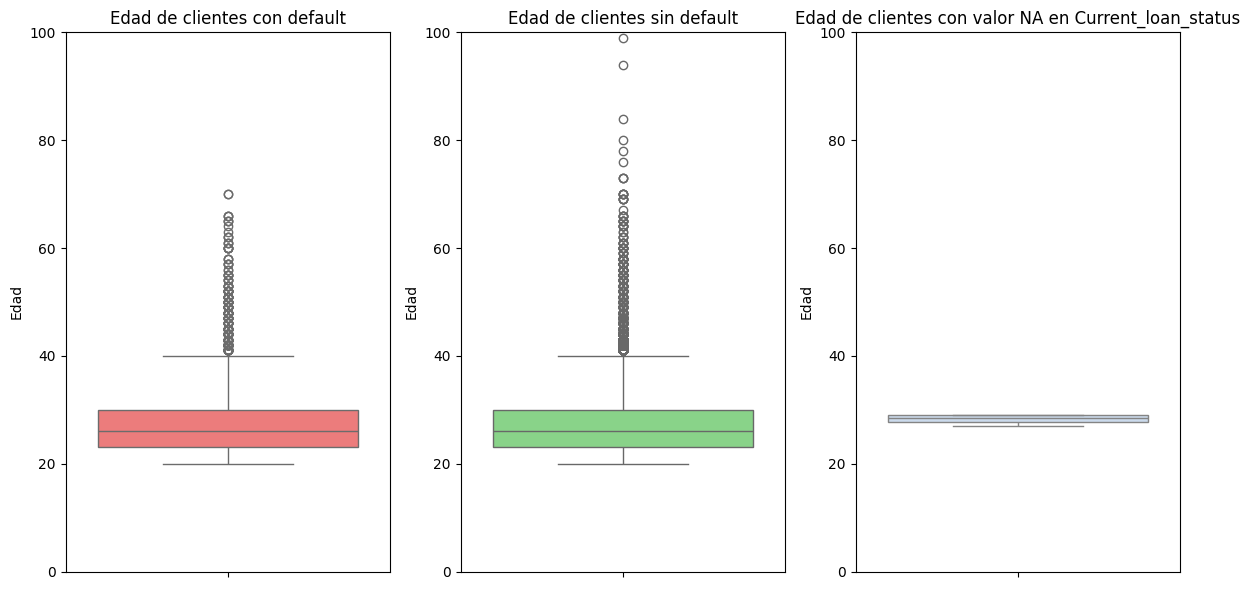

In [ ]:
# Definimos la escala del eje y para los gráficos para que cuenten con la misma escala
y_lim_min = 0  # Valor mínimo del eje y
y_lim_max = 100 # Valor máximo del eje y

plt.figure(figsize=(12, 6))

# Boxplot para default
plt.subplot(1, 3, 1)
sns.boxplot(y=loan_2[loan_2['Current_loan_status'] == True]['customer_age'], color='#FF6969')
plt.title('Edad de clientes con default')
plt.ylabel('Edad')
plt.ylim(y_lim_min, y_lim_max)


# Boxplot para no default
plt.subplot(1, 3, 2)
sns.boxplot(y=loan_2[loan_2['Current_loan_status'] == False]['customer_age'], color='#7DDF7D')
plt.title('Edad de clientes sin default')
plt.ylabel('Edad')
plt.ylim(y_lim_min, y_lim_max)


# Boxplot para NA (si existen)
plt.subplot(1, 3, 3)
sns.boxplot(y=loan_2[loan_2['Current_loan_status'].isna()]['customer_age'], color='#C6D9F1')
plt.title('Edad de clientes con valor NA en Current_loan_status')
plt.ylabel('Edad')
plt.ylim(y_lim_min, y_lim_max)

plt.tight_layout()
plt.show()


In [ ]:
# Agrupamos por estado del préstamo y calcular media y desviación estándar de la edad
edad_stats = loan_2.groupby('Current_loan_status')['customer_age'].agg(['mean', 'std']).rename(index={True: 'Default', False: 'No Default'})

# Redondear resultados para presentarlos
edad_stats = edad_stats.round(2)

# Mostrar la tabla
edad_stats

,mean,std
Current_loan_status,,
No Default,27.81,6.24
Default,27.38,6.09


In [ ]:
# Realizamos la prueba t-Student para ver si hay diferencias significativas
default_group = loan_2[loan_2['Current_loan_status'] == True]['customer_age']
no_default_group = loan_2[loan_2['Current_loan_status'] == False]['customer_age']

t_stat, p_value = ttest_ind(default_group, no_default_group, equal_var=False)

# Crear tabla resumen
tabla_ttest = pd.DataFrame({
    'Estadístico t': [t_stat],
    'Valor p': [p_value]
})
tabla_ttest

,Estadístico t,Valor p
0,-5.161921,2.487106e-07


## Customer_income

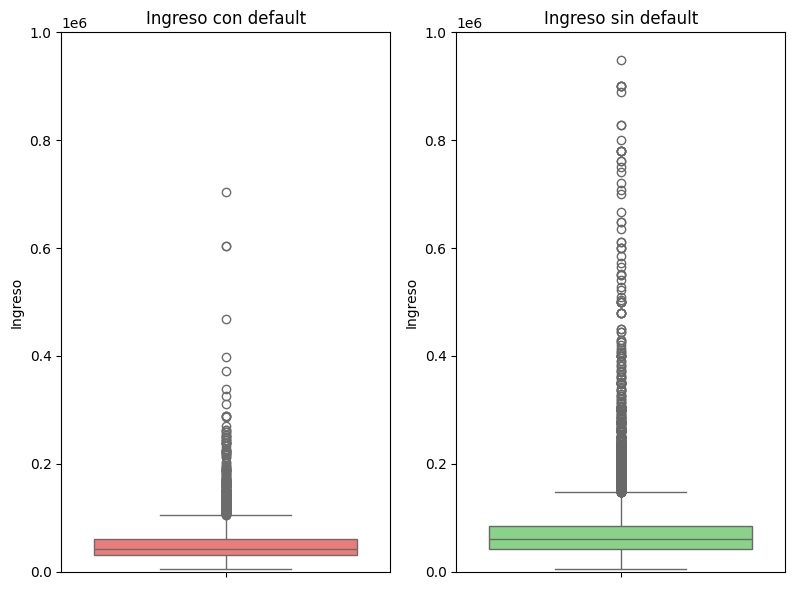

In [ ]:
# Definimos la escala del eje y para ambos boxplots
y_lim_min = 0  # Valor mínimo del eje y
y_lim_max = 1000000 # Valor máximo del eje y

plt.figure(figsize=(12, 6))

# Boxplot para default
plt.subplot(1, 3, 1)
sns.boxplot(y=loan_2[loan_2['Current_loan_status'] == True]['customer_income'], color='#FF6969')
plt.title('Ingreso con default')
plt.ylabel('Ingreso')
plt.ylim(y_lim_min, y_lim_max)


# Boxplot para no default
plt.subplot(1, 3, 2)
sns.boxplot(y=loan_2[loan_2['Current_loan_status'] == False]['customer_income'], color='#7DDF7D')
plt.title('Ingreso sin default')
plt.ylabel('Ingreso')
plt.ylim(y_lim_min, y_lim_max)



plt.tight_layout()
plt.show()

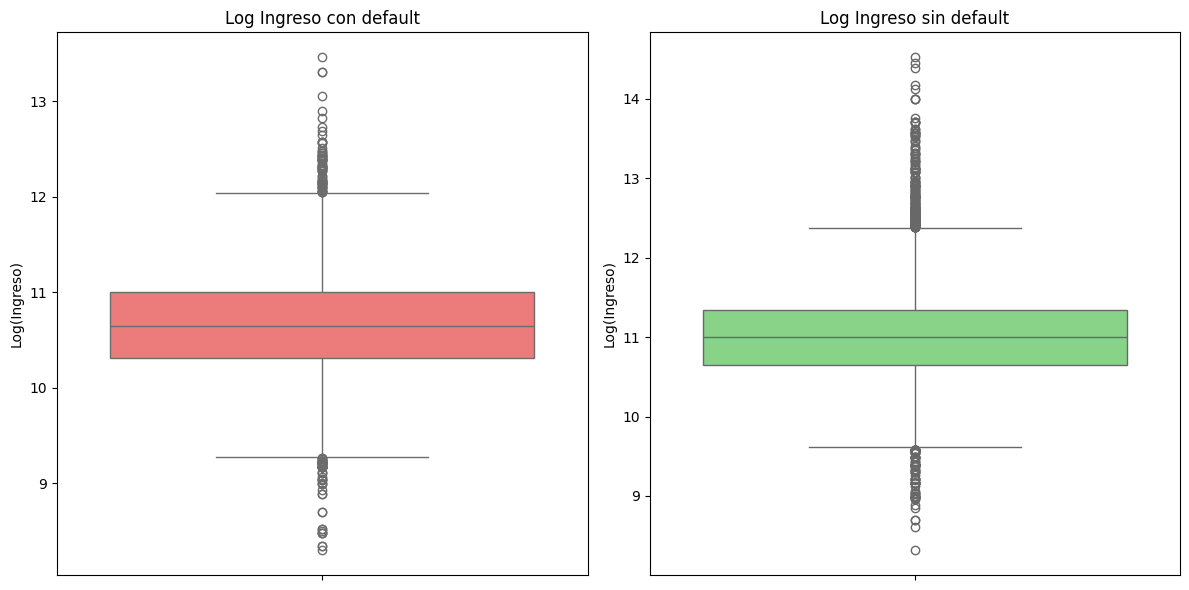

In [ ]:
# Como hizmos en el univariante, hacemos logaritmos para ver mejor las difernecias
loan_2['log_customer_income'] = np.log(loan_2['customer_income'])

plt.figure(figsize=(12, 6))

# Boxplot de default
plt.subplot(1, 2, 1)
sns.boxplot(y=loan_2[loan_2['Current_loan_status'] == True]['log_customer_income'], color='#FF6969')
plt.title('Log Ingreso con default')
plt.ylabel('Log(Ingreso)')


# Boxplot de no default
plt.subplot(1, 2, 2)
sns.boxplot(y=loan_2[loan_2['Current_loan_status'] == False]['log_customer_income'], color='#7DDF7D')
plt.title('Log Ingreso sin default')
plt.ylabel('Log(Ingreso)')

plt.tight_layout()
plt.show()

In [ ]:
# Agrupamos por estado del préstamo y calcular media y desviación estándar de la edad
income_stats = loan_2.groupby('Current_loan_status')['customer_income'].agg(['mean', 'std']).rename(index={True: 'Default', False: 'No Default'})

# Redondear resultados para presentarlos
income_stats = income_stats.round(2)

# Mostrar la tabla
income_stats

,mean,std
Current_loan_status,,
No Default,70325.89,55498.59
Default,49165.71,34659.89


In [ ]:
no_default_group = loan_2[loan_2['Current_loan_status'] == False]['customer_income']

# Test t de Student
t_stat, p_value = ttest_ind(default_group, no_default_group, equal_var=False)

# Crear tabla resumen
tabla_ttest = pd.DataFrame({
    'Estadístico t': [t_stat],
    'Valor p': [p_value]
})
tabla_ttest

,Estadístico t,Valor p
0,-203.197252,0.0


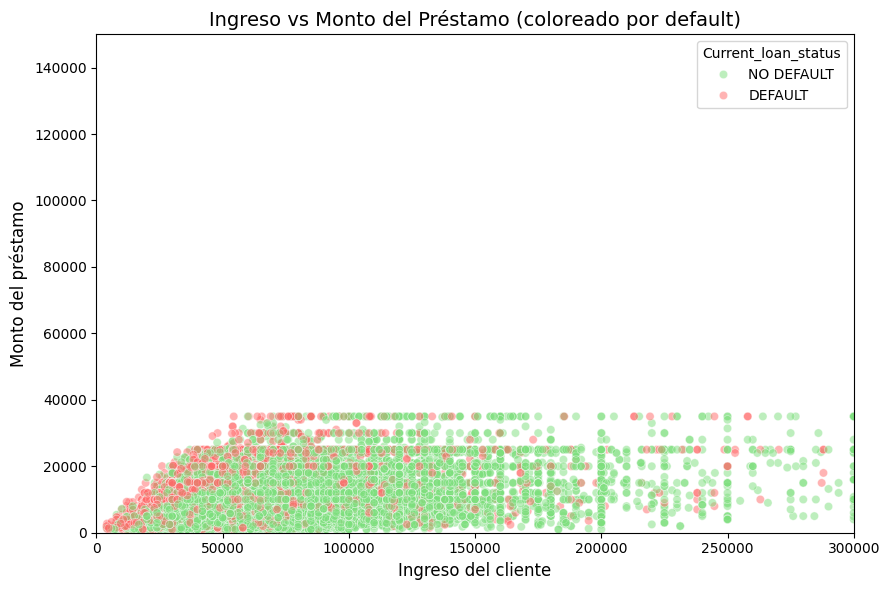

In [ ]:
#Scatterplot: customer_income vs loan_amnt
df_s = loan_2[loan_2["customer_income"].notna() & loan_2["loan_amnt"].notna() & loan_2["Current_loan_status"].notna()].copy()

df_s["Current_loan_status"] = df_s["Current_loan_status"].map({True: "DEFAULT", False: "NO DEFAULT"})

df_s["customer_income"] = pd.to_numeric(df_s["customer_income"], errors='coerce')
df_s["loan_amnt"] = pd.to_numeric(df_s["loan_amnt"], errors='coerce')

palette_custom = {"DEFAULT": "#FF6969", "NO DEFAULT": "#7DDF7D"}

fig, ax = plt.subplots(figsize=(9, 6))
sns.scatterplot(
    data=df_s,
    x="customer_income",
    y="loan_amnt",
    hue="Current_loan_status",
    alpha=0.5,
    palette=palette_custom,
    ax=ax
)

ax.set_title("Ingreso vs Monto del Préstamo (coloreado por default)", fontsize=14)
ax.set_xlabel("Ingreso del cliente", fontsize=12)
ax.set_ylabel("Monto del préstamo", fontsize=12)
ax.set_xlim(0, 300000)
ax.set_ylim(0, 150000)

plt.tight_layout()
plt.show()
#Muestra que los clientes en default (rojo) tienden a concentrarse en la zona de ingresos bajos y montos altos, lo cual visualiza bien el riesgo crediticio.
## Probarlo con una muestra estratificada

## DURACIÓN DEL EMPLEO

(0.0, 50.0)

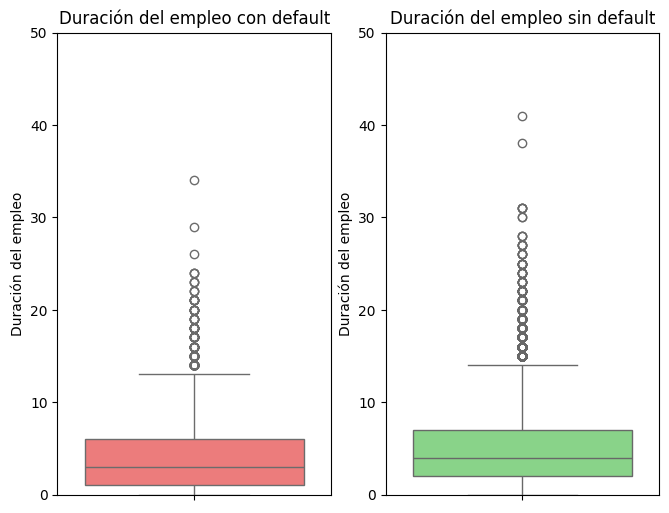

In [ ]:
y_lim_min = 0  # Valor mínimo del eje y
y_lim_max = 50 # Valor máximo del eje y

plt.figure(figsize=(12, 6))

# Boxplot para default
plt.subplot(1, 3, 1)
sns.boxplot(y=loan_2[loan_2['Current_loan_status'] == True]['employment_duration'], color='#FF6969')
plt.title('Duración del empleo con default')
plt.ylabel('Duración del empleo')
plt.ylim(y_lim_min, y_lim_max)


# Boxplot para no default
plt.subplot(1, 3, 2)
sns.boxplot(y=loan_2[loan_2['Current_loan_status'] == False]['employment_duration'], color='#7DDF7D')
plt.title('Duración del empleo sin default')
plt.ylabel('Duración del empleo')
plt.ylim(y_lim_min, y_lim_max)

In [ ]:
#Realizamos el T-student descartando NaN en employment_duration
t_stat, p_value = ttest_ind(
    loan_2.loc[
        loan_2['Current_loan_status'] & loan_2['employment_duration'].notna(),
        'employment_duration'
    ],
    loan_2.loc[
        (~loan_2['Current_loan_status']) & loan_2['employment_duration'].notna(),
        'employment_duration'
    ],
    equal_var=False
)

# Tabla resumen
tabla_ttest = pd.DataFrame({
    'Estadístico t': [t_stat],
    'Valor p':     [p_value]
})
display(tabla_ttest)

,Estadístico t,Valor p
0,-16.598191,4.028466e-61


## CANTIDAD DEL PRÉSTAMO

<ipython-input-142-1298399728>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x="Current_loan_status", y="loan_amnt", palette=palette_custom)


Text(0, 0.5, 'Monto del Préstamo')

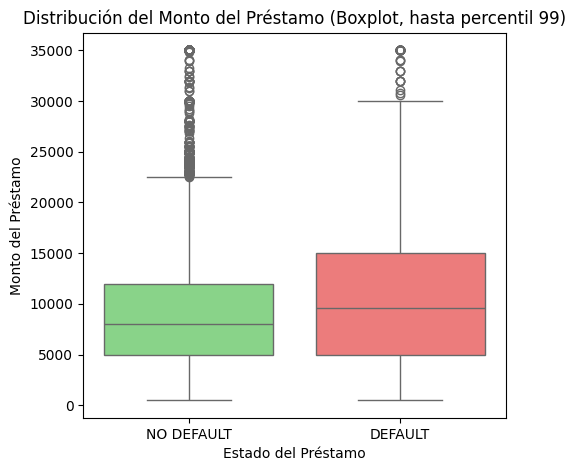

In [ ]:
df_plot = loan_2[loan_2["loan_amnt"].notna() & loan_2["Current_loan_status"].notna()].copy()
df_plot["Current_loan_status"] = df_plot["Current_loan_status"].map({True: "DEFAULT", False: "NO DEFAULT"})

# Limpiar loan_amnt (quitar símbolos como '£' y convertir a numérico)
df_plot["loan_amnt"] = pd.to_numeric(df_plot["loan_amnt"].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')

# Filtrar por el percentil 99
p99 = df_plot["loan_amnt"].quantile(0.9999)
df_filtered = df_plot[df_plot["loan_amnt"] <= p99]

# Colores personalizados
palette_custom = {"DEFAULT": "#FF6969", "NO DEFAULT": "#7DDF7D"}

# Crear figura
plt.figure(figsize=(12, 5))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=df_filtered, x="Current_loan_status", y="loan_amnt", palette=palette_custom)
plt.title("Distribución del Monto del Préstamo (Boxplot, hasta percentil 99)")
plt.xlabel("Estado del Préstamo")
plt.ylabel("Monto del Préstamo")

In [ ]:
# Agrupamos por estado del préstamo y calcular media y desviación estándar de la edad
cantidad_prestamo_stats = loan_2.groupby('Current_loan_status')['loan_amnt'].agg(['mean', 'std']).rename(index={True: 'Default', False: 'No Default'})

cantidad_prestamo_stats = cantidad_prestamo_stats.round(2)

cantidad_prestamo_stats

,mean,std
Current_loan_status,,
No Default,9421.03,22597.70
Default,11011.09,18301.94


In [ ]:
no_default_group = loan_2[loan_2['Current_loan_status'] == False]['loan_amnt']

# Test t de Student
t_stat, p_value = ttest_ind(default_group, no_default_group, equal_var=False)

# Crear tabla resumen
tabla_ttest = pd.DataFrame({
    'Estadístico t': [t_stat],
    'Valor p': [p_value]
})
tabla_ttest

,Estadístico t,Valor p
0,-66.684323,0.0


## TASA DE INTERÉS

<ipython-input-146-1998211905>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_v1, x="Current_loan_status", y="loan_int_rate", palette=palette_custom, ax=ax)


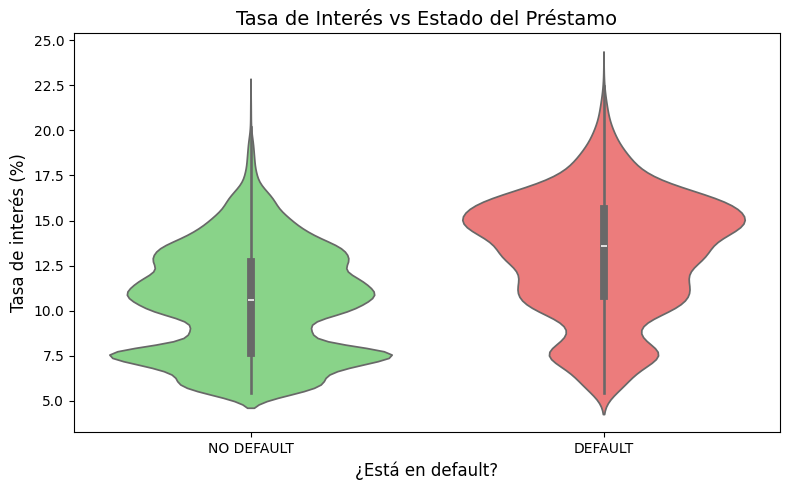

In [ ]:
default = loan_2[loan_2['Current_loan_status'] == True]['loan_int_rate']
no_default = loan_2[loan_2['Current_loan_status'] == False]['loan_int_rate']

df_v1 = loan_2[loan_2["loan_int_rate"].notna() & loan_2["Current_loan_status"].notna()].copy()

df_v1["Current_loan_status"] = loan_2["Current_loan_status"].map({True: "DEFAULT", False: "NO DEFAULT"})

palette_custom = {'DEFAULT': '#FF6969', 'NO DEFAULT': '#7DDF7D'}

fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(data=df_v1, x="Current_loan_status", y="loan_int_rate", palette=palette_custom, ax=ax)

ax.set_title("Tasa de Interés vs Estado del Préstamo", fontsize=14)
ax.set_xlabel("¿Está en default?", fontsize=12)
ax.set_ylabel("Tasa de interés (%)", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
interes_stats = loan_2.groupby('Current_loan_status')['loan_int_rate'].agg(['mean', 'std']).rename(index={True: 'Default', False: 'No Default'})

interes_stats = interes_stats.round(2)

interes_stats

,mean,std
Current_loan_status,,
No Default,10.44,2.98
Default,13.13,3.30


In [ ]:
# Hacemos una copia de loan_2
loan_3 = loan_2.copy()

In [ ]:
loan_3.shape

(29461, 14)

In [ ]:
# Vemos los valores nulos de loan_int_rate en loan_3
loan_3['loan_int_rate'].isnull().sum()


np.int64(3115)

In [ ]:
# Borramos los valores nulos de loan_int_rate en loan_2 para poder ver el t-student
loan_3 = loan_3.dropna(subset=['loan_int_rate'])


In [ ]:
# Vemos si quedan valores nulos en loan_int_rate

print(f"Número de valores nulos en 'loan_int_rate': {loan_3['loan_int_rate'].isnull().sum()}")


Número de valores nulos en 'loan_int_rate': 0


In [ ]:
no_default_group = loan_3[loan_3['Current_loan_status'] == False]['loan_int_rate']

# Test t de Student
t_stat, p_value = ttest_ind(default_group, no_default_group, equal_var=False)

# Crear tabla resumen
tabla_ttest = pd.DataFrame({
    'Estadístico t': [t_stat],
    'Valor p': [p_value]
})
tabla_ttest

,Estadístico t,Valor p
0,222.172451,0.0


## DURACIÓN DEL PRÉSTAMO

<ipython-input-159-4223016230>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=loan_2, x="Current_loan_status", y="term_years", palette=palette_custom, ax=ax)


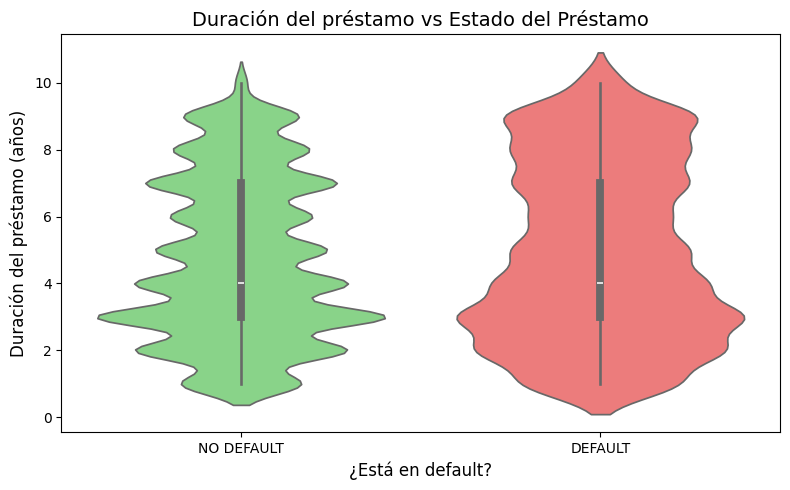

In [ ]:
loan_2 = loan_2[loan_2["term_years"].notna() & loan_2["Current_loan_status"].notna()].copy()

loan_2["Current_loan_status"] = loan_2["Current_loan_status"].map({True: "DEFAULT", False: "NO DEFAULT"})

palette_custom = {'DEFAULT': '#FF6969', 'NO DEFAULT': '#7DDF7D'}

fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(data=loan_2, x="Current_loan_status", y="term_years", palette=palette_custom, ax=ax)

ax.set_title("Duración del préstamo vs Estado del Préstamo", fontsize=14)
ax.set_xlabel("¿Está en default?", fontsize=12)
ax.set_ylabel("Duración del préstamo (años)", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
print(loan_2['Current_loan_status'].value_counts())
print(loan_2.groupby('Current_loan_status')['term_years']
             .apply(lambda x: x.dropna().shape[0]))

Current_loan_status
NO DEFAULT    25734
DEFAULT        6838
Name: count, dtype: int64
Current_loan_status
DEFAULT        6838
NO DEFAULT    25734
Name: term_years, dtype: int64


In [ ]:
t_stat, p_value = ttest_ind(
    *(loan_2.loc[loan_2['Current_loan_status']==status, 'term_years']
      for status in ['DEFAULT', 'NO DEFAULT']),
    equal_var=False,
    nan_policy='omit'
)

print(f"t = {t_stat:.4f}, p = {p_value:.3g}")

t = 5.7691, p = 8.21e-09


In [ ]:
duracion_prestamo_stats = loan_2.groupby('Current_loan_status')['term_years'].agg(['mean', 'std']).rename(index={True: 'Default', False: 'No Default'})
duracion_prestamo_stats = duracion_prestamo_stats.round(2)
duracion_prestamo_stats

,mean,std
Current_loan_status,,
DEFAULT,4.92,2.66
NO DEFAULT,4.72,2.41


## **VARIABLES CATEGÓRICAS**

## TIPO DE VIVIENDA

In [ ]:
# Creamos una tabla de contingencia
contingencia_tipo_vivienda = pd.crosstab(loan_2['home_ownership'], loan_2['Current_loan_status'])

contingencia_tipo_vivienda

Current_loan_status,DEFAULT,NO DEFAULT
home_ownership,,
MORTGAGE,1556,11882
OTHER,33,74
OWN,157,2426
RENT,5092,11352


In [ ]:
chi2, p, dof, expected = chi2_contingency(contingencia_tipo_vivienda)

tabla_chi2 = pd.DataFrame({
    'Estadístico Chi-cuadrado': [round(chi2, 2)],
    'Grados de libertad': [dof],
    'Valor p': [round(p, 4)],
    'Conclusión': ["Existe una relación significativa" if p < 0.05 else "No hay relación significativa"]
})
tabla_chi2

,Estadístico Chi-cuadrado,Grados de libertad,Valor p,Conclusión
0,2056.71,3,0.0,Existe una relación significativa


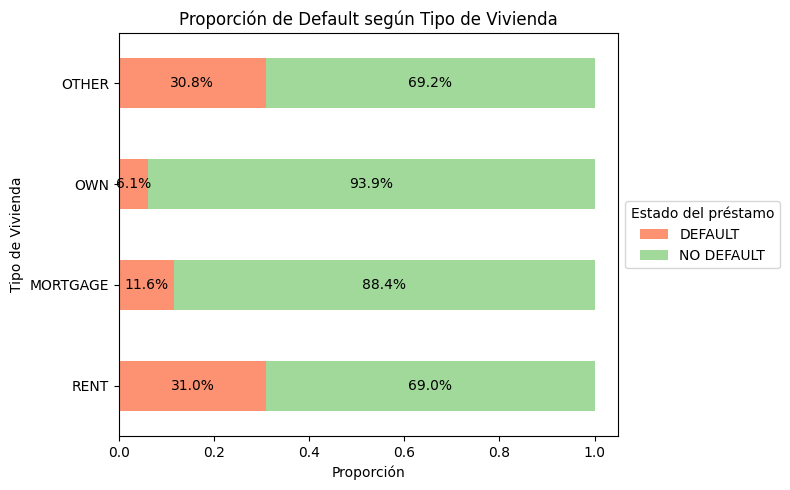

In [ ]:
# Agrupamos y calculamos proporciones por categoría de loan_intent y estado del préstamo
prop_df = loan_2.groupby(['home_ownership', 'Current_loan_status']).size().reset_index(name='count')
total = prop_df.groupby('home_ownership')['count'].transform('sum')
prop_df['percent'] = prop_df['count'] / total

# Pivot para gráfico
pivot_df = prop_df.pivot(index='home_ownership', columns='Current_loan_status', values='percent')
order = loan_2['home_ownership'].value_counts().index.tolist()
pivot_df = pivot_df.loc[order]

colors = ['#fc9272','#a1d99b']

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(8, 5))
bars = pivot_df.plot(kind='barh', stacked=True, color=colors, ax=ax)

for i, row in enumerate(pivot_df.itertuples(index=False)):
    left = 0
    for j, width in enumerate(row):
        if width > 0:
            label = f"{width * 100:.1f}%"
            ax.text(left + width / 2, i, label, va='center', ha='center', fontsize=10, color='black')
        left += width

ax.set_xlabel('Proporción')
ax.set_ylabel('Tipo de Vivienda')
ax.set_title('Proporción de Default según Tipo de Vivienda')

# Leyenda fuera del gráfico
ax.legend(
    title='Estado del préstamo',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)

plt.tight_layout()
plt.show()

## LOAN_INTENT

In [ ]:
# Crear tabla de contingencia
contingencia_loan_intent = pd.crosstab(loan_2['loan_intent'], loan_2['Current_loan_status'])
contingencia_loan_intent

Current_loan_status,DEFAULT,NO DEFAULT
loan_intent,,
DEBTCONSOLIDATION,1583,3629
EDUCATION,1026,5424
HOMEIMPROVEMENT,882,2724
MEDICAL,1523,4548
PERSONAL,1022,4497
VENTURE,802,4912


In [ ]:
# Test de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingencia_loan_intent)

tabla_chi2 = pd.DataFrame({
    'Estadístico Chi-cuadrado': [round(chi2, 2)],
    'Grados de libertad': [dof],
    'Valor p': [round(p, 4)],
    'Conclusión': ["Existe una relación significativa" if p < 0.05 else "No hay relación significativa"]
})
tabla_chi2

,Estadístico Chi-cuadrado,Grados de libertad,Valor p,Conclusión
0,652.95,5,0.0,Existe una relación significativa


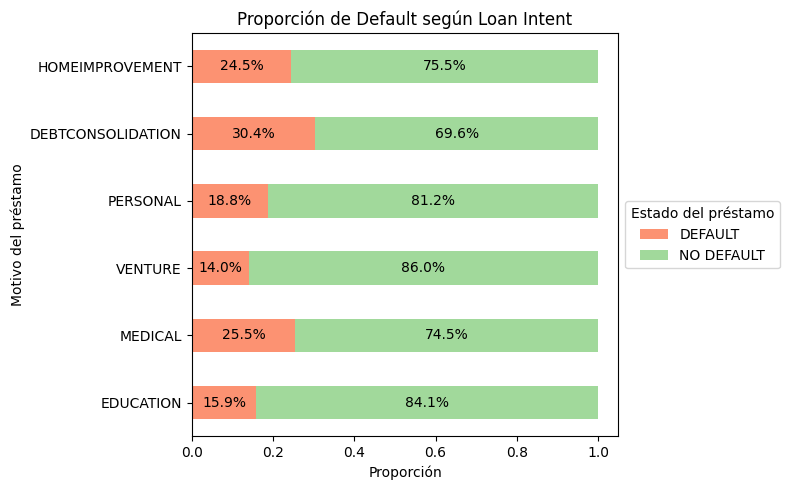

In [ ]:
# Agrupamos y calculamos proporciones por categoría de loan_intent y estado del préstamo
prop_df = loan_2.groupby(['loan_intent', 'Current_loan_status']).size().reset_index(name='count')
total = prop_df.groupby('loan_intent')['count'].transform('sum')
prop_df['percent'] = prop_df['count'] / total

pivot_df = prop_df.pivot(index='loan_intent', columns='Current_loan_status', values='percent')
order = loan_2['loan_intent'].value_counts().index.tolist()
pivot_df = pivot_df.loc[order]

colors = [ '#fc9272','#a1d99b']

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(8, 5))
bars = pivot_df.plot(kind='barh', stacked=True, color=colors, ax=ax)

for i, row in enumerate(pivot_df.itertuples(index=False)):
    left = 0
    for j, width in enumerate(row):
        if width > 0:
            label = f"{width * 100:.1f}%"
            ax.text(left + width / 2, i, label, va='center', ha='center', fontsize=10, color='black')
        left += width

ax.set_xlabel('Proporción')
ax.set_ylabel('Motivo del préstamo')
ax.set_title('Proporción de Default según Loan Intent')

ax.legend(
    title='Estado del préstamo',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)

plt.tight_layout()
plt.show()

## LOAN GRADE

In [ ]:
contingencia_loan_grade = pd.crosstab(loan_2['loan_grade'], loan_2['Current_loan_status'])
contingencia_loan_grade

Current_loan_status,DEFAULT,NO DEFAULT
loan_grade,,
A,1566,14088
B,1751,7311
C,1760,3163
D,1540,1088
E,221,84


In [ ]:
# Test de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingencia_loan_grade)

tabla_chi2 = pd.DataFrame({
    'Estadístico Chi-cuadrado': [chi2],
    'Grados de libertad': [dof],
    'Valor p': [p],
    'Conclusión': ["Existe una relación significativa" if p < 0.05 else "No hay relación significativa"]
})
tabla_chi2

,Estadístico Chi-cuadrado,Grados de libertad,Valor p,Conclusión
0,4529.30485,4,0.0,Existe una relación significativa


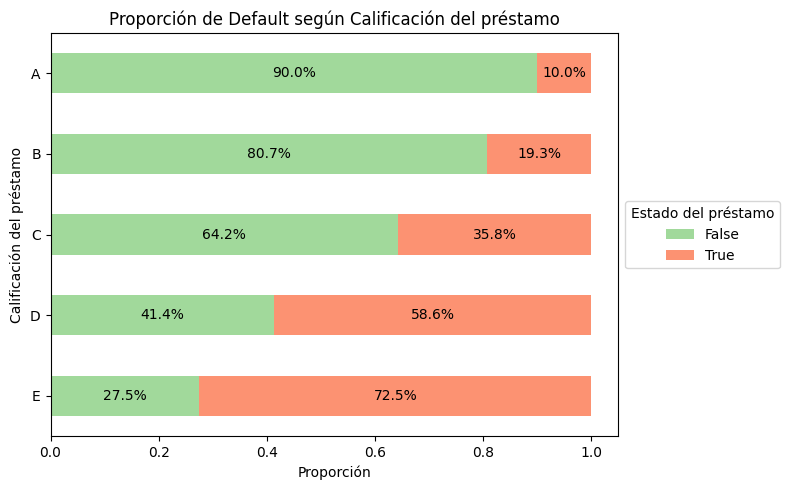

In [ ]:
# Agrupamos y calculamos proporciones por categoría de loan_grade y estado del préstamo
prop_df = loan.groupby(['loan_grade', 'Current_loan_status']).size().reset_index(name='count')
total = prop_df.groupby('loan_grade')['count'].transform('sum')
prop_df['percent'] = prop_df['count'] / total

pivot_df = prop_df.pivot(index='loan_grade', columns='Current_loan_status', values='percent')

order = sorted(loan_2['loan_grade'].dropna().unique(), reverse = True)
pivot_df = pivot_df.loc[order]

colors = ['#a1d99b','#fc9272']

# Creamos gráfico
fig, ax = plt.subplots(figsize=(8, 5))
bars = pivot_df.plot(kind='barh', stacked=True, color=colors, ax=ax)

for i, row in enumerate(pivot_df.itertuples(index=False)):
    left = 0
    for j, width in enumerate(row):
        if width > 0:
            label = f"{width * 100:.1f}%"
            ax.text(left + width / 2, i, label, va='center', ha='center', fontsize=10, color='black')
        left += width

ax.set_xlabel('Proporción')
ax.set_ylabel('Calificación del préstamo')
ax.set_title('Proporción de Default según Calificación del préstamo')

ax.legend(title='Estado del préstamo', loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()

## HISTORIAL CREDITICIO

In [ ]:
contingencia_historial = pd.crosstab(loan_2['historical_default'], loan_2['Current_loan_status'])
contingencia_historial

Current_loan_status,DEFAULT,NO DEFAULT
historical_default,,
False,4567,1146
True,2271,3856


In [ ]:
prop_hist = round(contingencia_historial.div(contingencia_historial.sum(axis=1), axis=0)*100,2)
prop_hist

Current_loan_status,DEFAULT,NO DEFAULT
historical_default,,
False,79.94,20.06
True,37.07,62.93


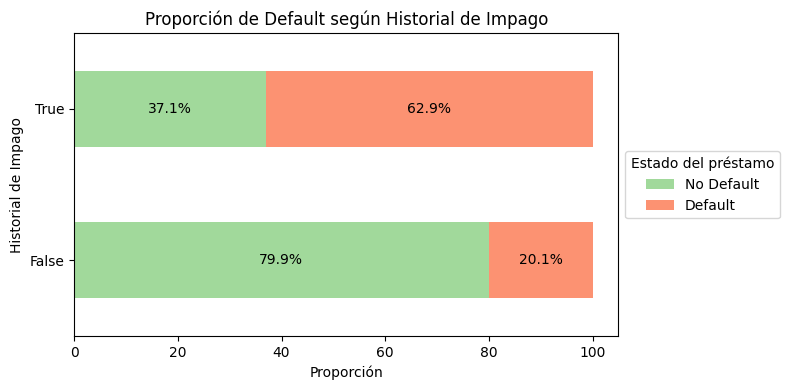

In [ ]:
ig, ax = plt.subplots(figsize=(8, 4))
colors = ['#a1d99b','#fc9272']  # Colores para No Default y Default
bars = prop_hist.plot(kind='barh', stacked=True, color=colors, ax=ax)

for i, row in enumerate(prop_hist.itertuples(index=False)):
    left = 0
    for j, width in enumerate(row):
        if width > 0:
            label = f"{width * 1:.1f}%"
            ax.text(left + width / 2, i, label, va='center', ha='center', fontsize=10, color='black')
        left += width

ax.set_xlabel('Proporción')
ax.set_ylabel('Historial de Impago')
ax.set_title('Proporción de Default según Historial de Impago')
ax.legend(title='Estado del préstamo', labels=['No Default', 'Default'], loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
# Ejecutar test de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingencia_historial)

tabla_chi = pd.DataFrame({
    'Estadístico': ['Chi-cuadrado', 'Grados de Libertad', 'P-valor'],
    'Valor': [chi2, dof, p]
})
tabla_chi

,Estadístico,Valor
0,Chi-cuadrado,2225.652607
1,Grados de Libertad,1.000000
2,P-valor,0.000000


## **VALORES NULOS**

In [ ]:
# Vemos los valores nulos por variable en loan_2

styled_nulls = loan_2.isnull().sum().reset_index()
styled_nulls.columns = ['Columna', 'Cantidad de nulos']

styled_nulls_table = styled_nulls.style.set_table_styles([header_style, cell_style])
display(styled_nulls_table)

,Columna,Cantidad de nulos
0,customer_id,3
1,customer_age,0
2,customer_income,0
3,home_ownership,0
4,employment_duration,895
5,loan_intent,0
6,loan_grade,0
7,loan_amnt,1
8,loan_int_rate,3114
9,term_years,0


In [ ]:
# Validamos los customer ids que se repiten
customer_id_repetidos = loan['customer_id'].value_counts()[loan['customer_id'].value_counts() > 1].index.tolist()

print(f"Los customer_id que se repiten son: {customer_id_repetidos}")
loan.duplicated().sum()

Los customer_id que se repiten son: [30285, 14688, 14689, 324, 323, 30284]


np.int64(6)

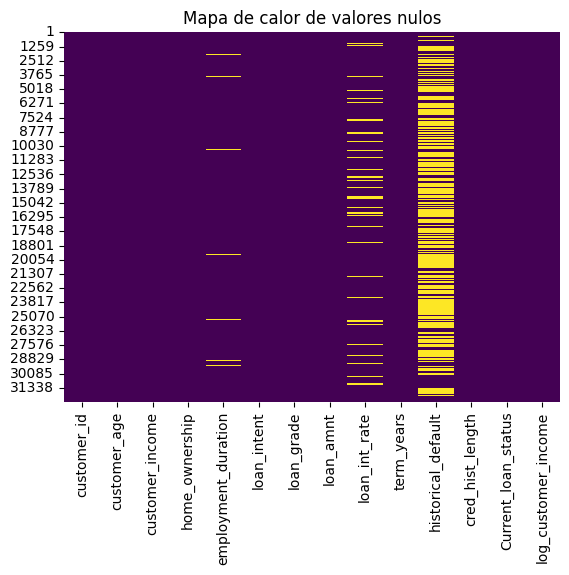

In [ ]:
#Validamos relaciones con los nulos
sns.heatmap(loan_2.isnull(), cbar=False, cmap="viridis")
plt.title("Mapa de calor de valores nulos")
plt.show()

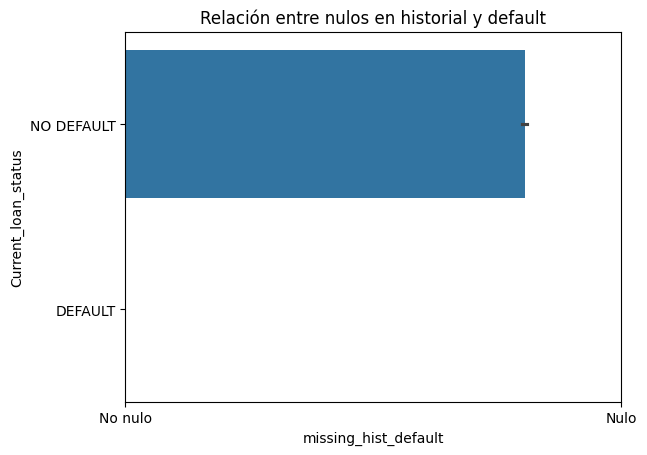

In [ ]:
#Analizamos la relacion de la variable con nulos con la target. Esto nos muestra la proporción de datos dentro de cada
#categoría que tienden a ser default, es decir vemos que los nulos tienen una baja probabilidad de default mientras que
#los no nulos tienen del 50-60%

loan_2['missing_hist_default'] = loan_2['historical_default'].isnull().astype(int)

sns.barplot(x='missing_hist_default', y='Current_loan_status', data=loan_2)
plt.xticks([0,1], ['No nulo', 'Nulo'])
plt.title("Relación entre nulos en historial y default")
plt.show()

#CONCLUSIONES:
#Podría haber un sesgo: quizás los que no tienen historial todavía no han tenido oportunidad de incumplir, o son nuevos
#clientes.
#También podría indicar que historical_default no se registra si no hay incumplimientos (y no si hubo cumplimiento), lo
#cual es común en algunos registros.

In [ ]:
result = loan_2.groupby('Current_loan_status')['historical_default'].apply(lambda x: x.isnull().value_counts(normalize=True))

result.index.names = ['Current_loan_status', 'historical_default_missing']

result = result.rename(index={True: 'Missing', False: 'Not Missing'}, level=1)

print(result)

#Aquí vemos que el 100% de los creditos con defualt no tienen valores nulos en la variable de historical default.

Current_loan_status  historical_default_missing
DEFAULT              Not Missing                   1.000000
NO DEFAULT           Missing                       0.805627
                     Not Missing                   0.194373
Name: historical_default, dtype: float64


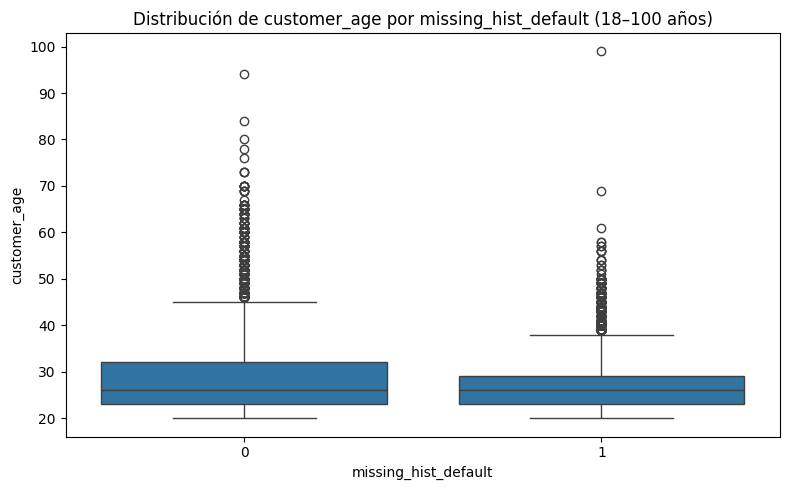

In [ ]:
# Marcar missing_hist_default
loan_2['missing_hist_default'] = loan_2['historical_default'].isna().astype(int)

# Boxplot para customer_age
plt.figure(figsize=(8, 5))
sns.boxplot(data=loan_2, x='missing_hist_default', y='customer_age')
plt.title("Distribución de customer_age por missing_hist_default (18–100 años)")
plt.xlabel("missing_hist_default")
plt.ylabel("customer_age")
plt.tight_layout()
plt.show()

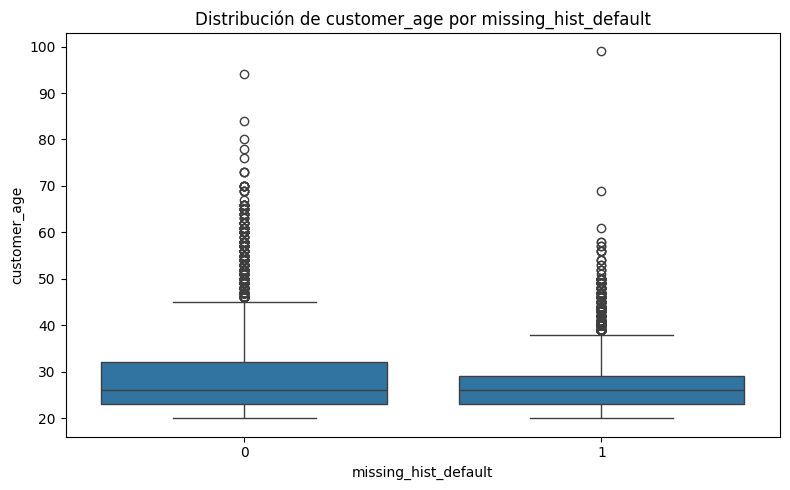

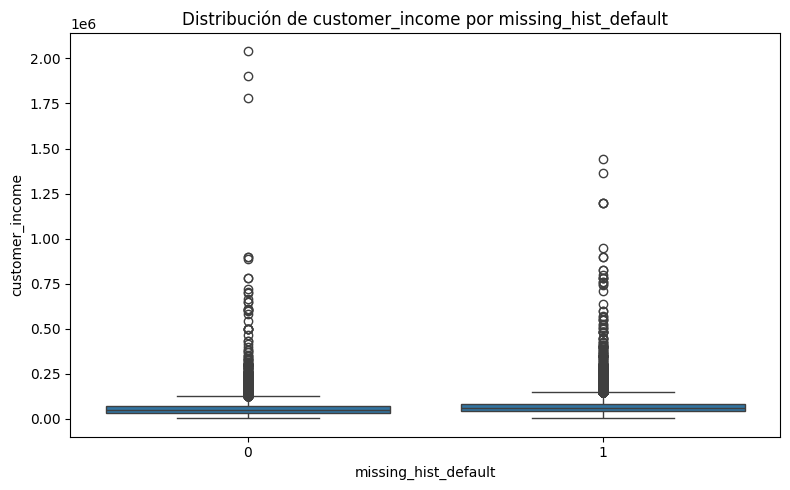

<Figure size 800x500 with 0 Axes>

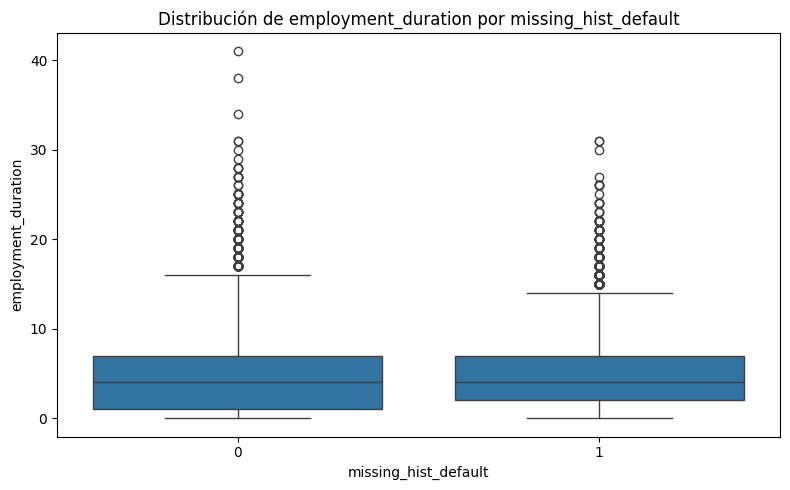

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

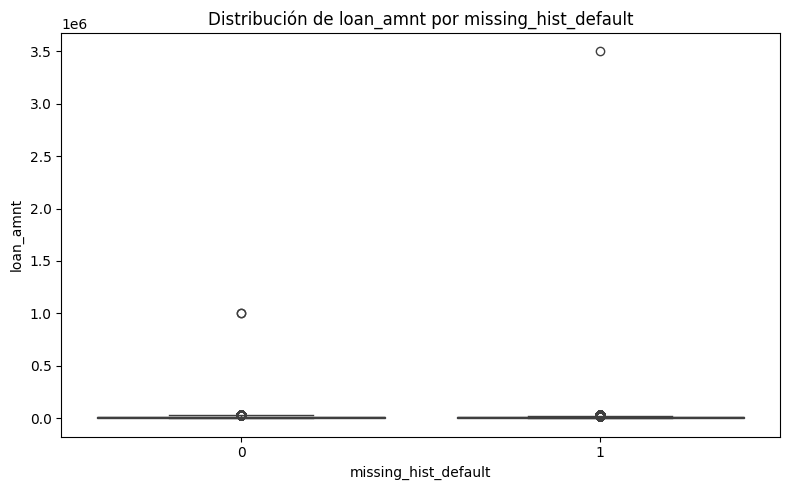

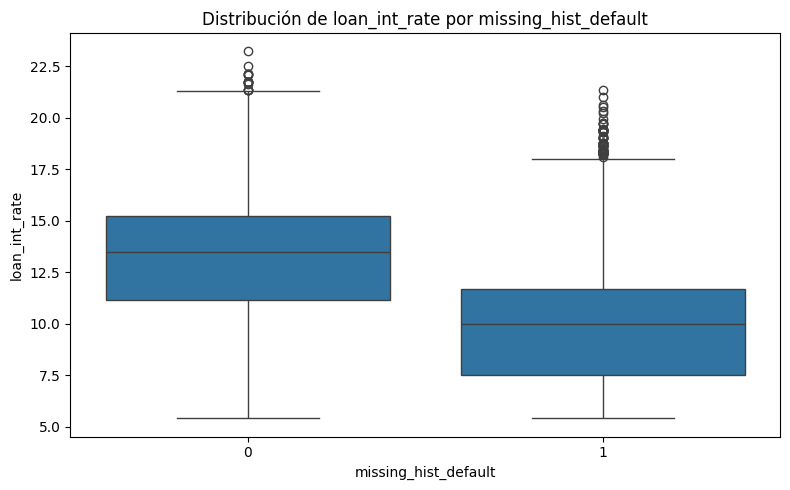

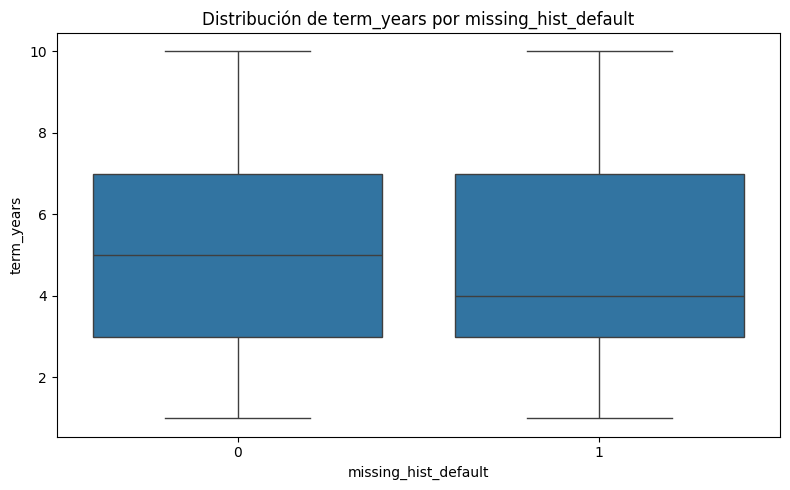

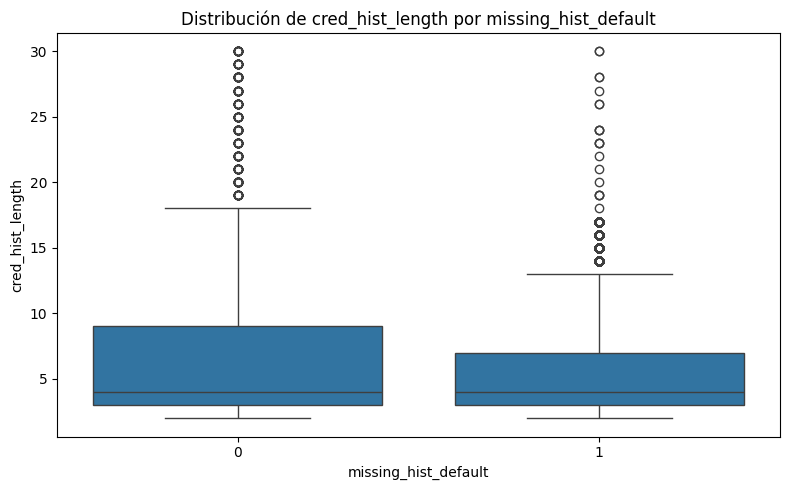

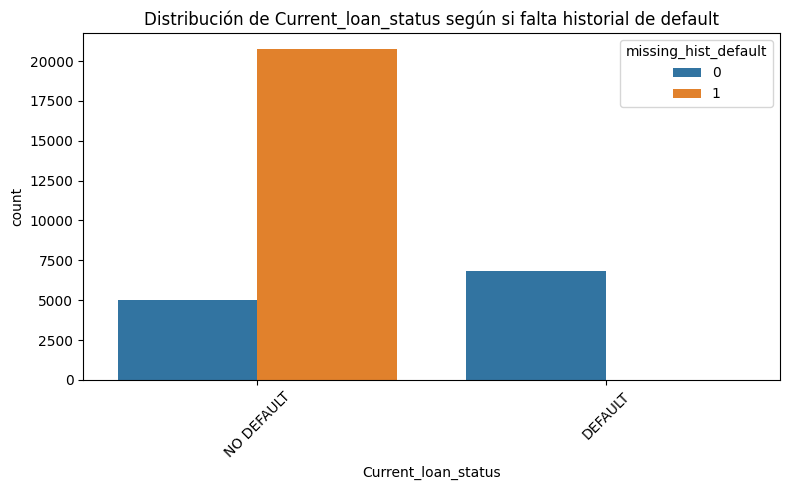

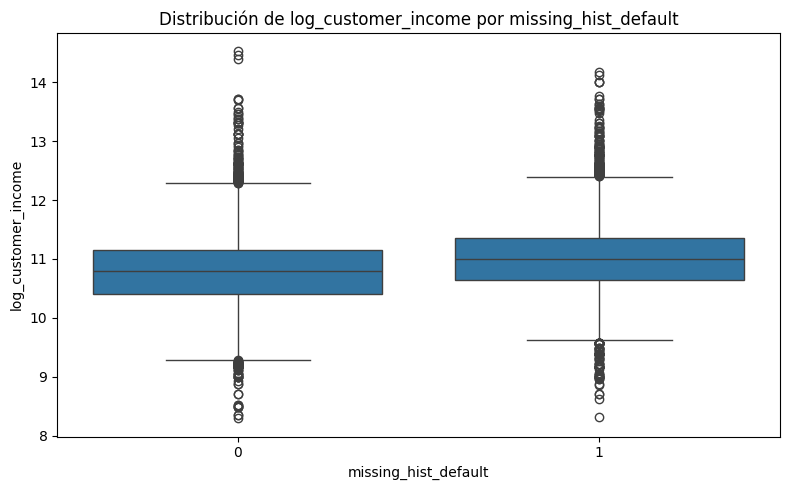

In [ ]:
#Vemos la relacion de los missing de historical default con el resto de las varaibles.
# Excluimos las columnas no relevantes
exclude_cols = ['customer_id', 'historical_default', 'missing_hist_default']

# Generar gráficos
for col in loan_2.columns:
    if col in exclude_cols:
        continue

    plt.figure(figsize=(8, 5))

    # Check the dtype using loan_2 instead of loan
    if loan_2[col].dtype == 'object':
        # Gráfico de barras para variables categóricas
        sns.countplot(data=loan_2, x=col, hue='missing_hist_default')
        plt.title(f"Distribución de {col} según si falta historial de default")
        plt.xticks(rotation=45)
        plt.tight_layout()

    # Check the dtype using loan_2 instead of loan
    elif pd.api.types.is_numeric_dtype(loan_2[col]):
        # Boxplot para variables numéricas
        sns.boxplot(data=loan_2, x='missing_hist_default', y=col)
        plt.title(f"Distribución de {col} por missing_hist_default")
        plt.tight_layout()

    plt.show()

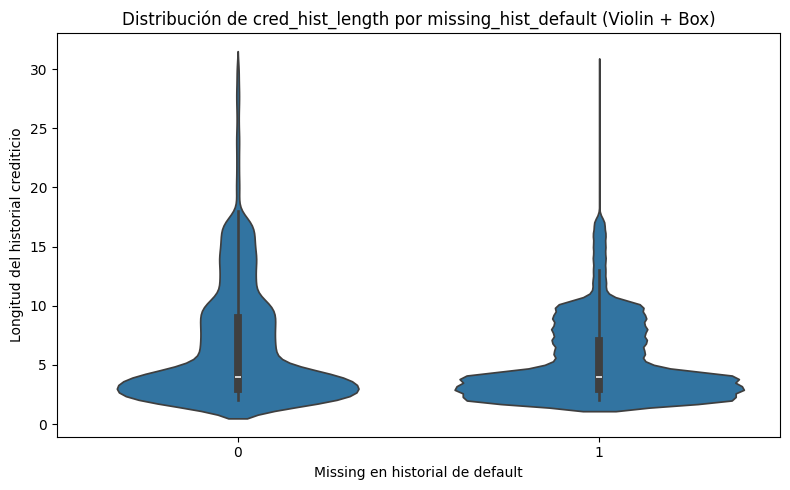

In [ ]:
#Nos concentramos en la relacion de los missing con el credit history lenght

plt.figure(figsize=(8, 5))
sns.violinplot(data=loan_2, x='missing_hist_default', y='cred_hist_length', inner='box')
plt.title("Distribución de cred_hist_length por missing_hist_default (Violin + Box)")
plt.xlabel("Missing en historial de default")
plt.ylabel("Longitud del historial crediticio")
plt.tight_layout()
plt.show()

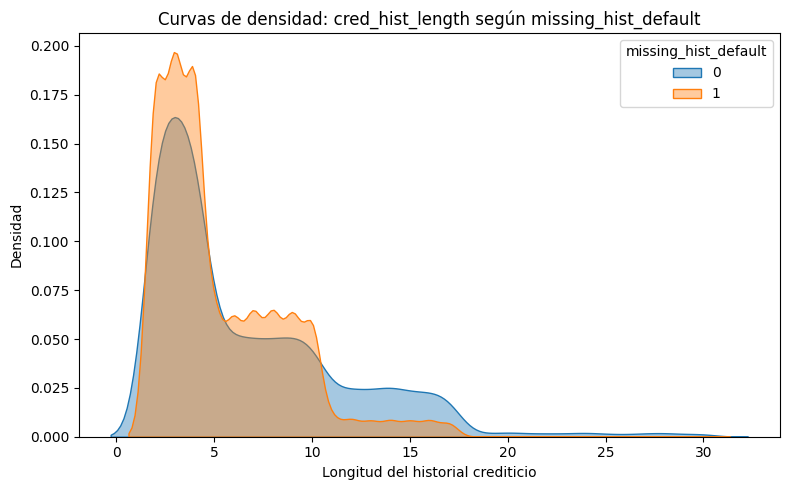

In [ ]:
plt.figure(figsize=(8, 5))
for label, group in loan_2.groupby('missing_hist_default'):
    sns.kdeplot(group['cred_hist_length'].dropna(), label=label, fill=True, alpha=0.4)

plt.title("Curvas de densidad: cred_hist_length según missing_hist_default")
plt.xlabel("Longitud del historial crediticio")
plt.ylabel("Densidad")
plt.legend(title="missing_hist_default")
plt.tight_layout()
plt.show()

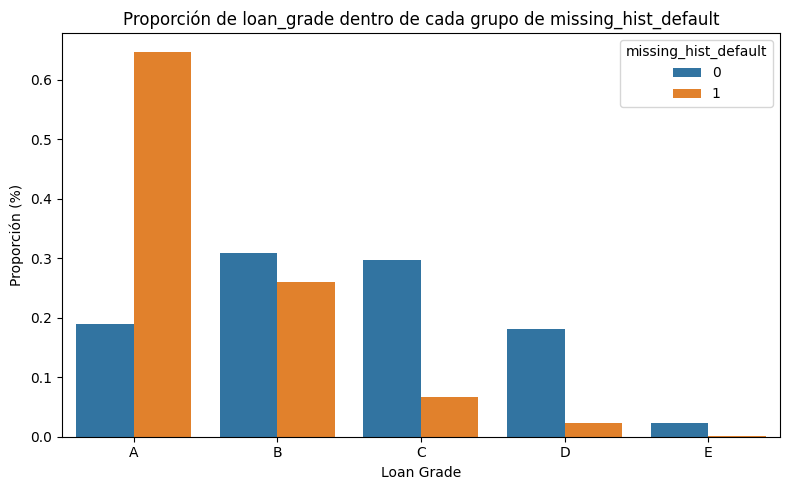

In [ ]:
#Vemos la relación de el loan grade con el missing default
# Definir el orden deseado de los niveles
grade_order = ['A', 'B', 'C', 'D', 'E']

# Asegurarse de que loan_grade tenga el orden correcto como categoría
loan_2['loan_grade'] = pd.Categorical(loan_2['loan_grade'], categories=grade_order, ordered=True)

# Calcular proporciones por grupo
prop_df = (
    loan_2.groupby('missing_hist_default')['loan_grade']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
)

# Ordenar según categoría
prop_df['loan_grade'] = pd.Categorical(prop_df['loan_grade'], categories=grade_order, ordered=True)
prop_df = prop_df.sort_values('loan_grade')

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(data=prop_df, x='loan_grade', y='proportion', hue='missing_hist_default')
plt.title("Proporción de loan_grade dentro de cada grupo de missing_hist_default")
plt.ylabel("Proporción (%)")
plt.xlabel("Loan Grade")
plt.tight_layout()
plt.show()

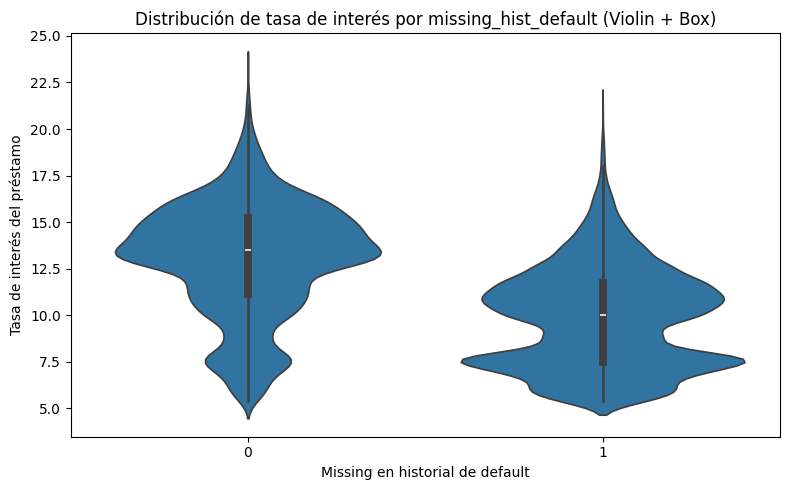

In [ ]:
# Gráfico de violín
plt.figure(figsize=(8, 5))
sns.violinplot(data=loan_2, x='missing_hist_default', y='loan_int_rate', inner='box')
plt.title("Distribución de tasa de interés por missing_hist_default (Violin + Box)")
plt.xlabel("Missing en historial de default")
plt.ylabel("Tasa de interés del préstamo")
plt.tight_layout()
plt.show()

<ipython-input-216-3741152463>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=loan_2, x='loan_grade', y='loan_int_rate', order=['A', 'B', 'C', 'D', 'E'], inner='box', palette=grade_palette_gradient)


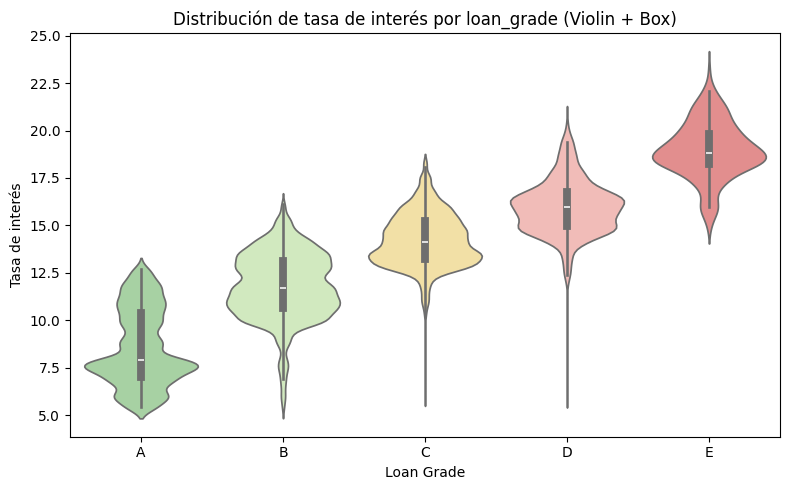

In [ ]:
#Vemos la relación de las tasas de interes con el loan grade
# Creamos una paleta de colores para el degradado basado en el orden de los grados A-E
grade_palette_gradient = ['#a1d99b', '#d0f0b8', '#ffe699', '#fbb4ae', '#f08080']

plt.figure(figsize=(8, 5))
sns.violinplot(data=loan_2, x='loan_grade', y='loan_int_rate', order=['A', 'B', 'C', 'D', 'E'], inner='box', palette=grade_palette_gradient)
plt.title("Distribución de tasa de interés por loan_grade (Violin + Box)")
plt.xlabel("Loan Grade")
plt.ylabel("Tasa de interés")
plt.tight_layout()
plt.show()


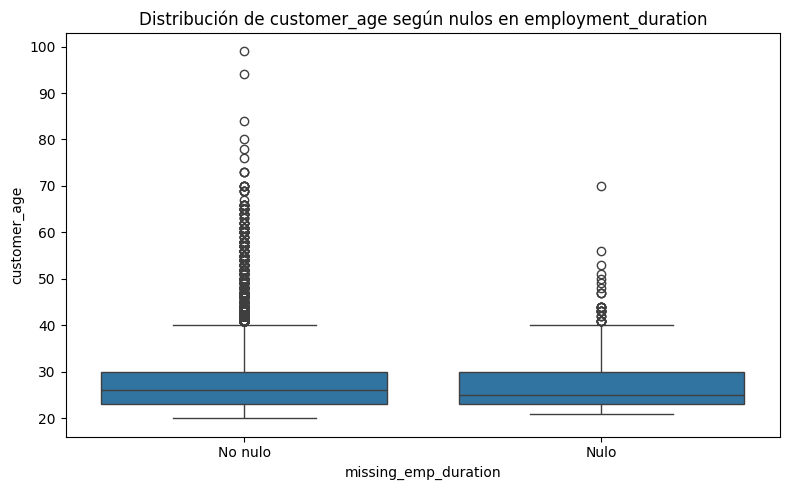

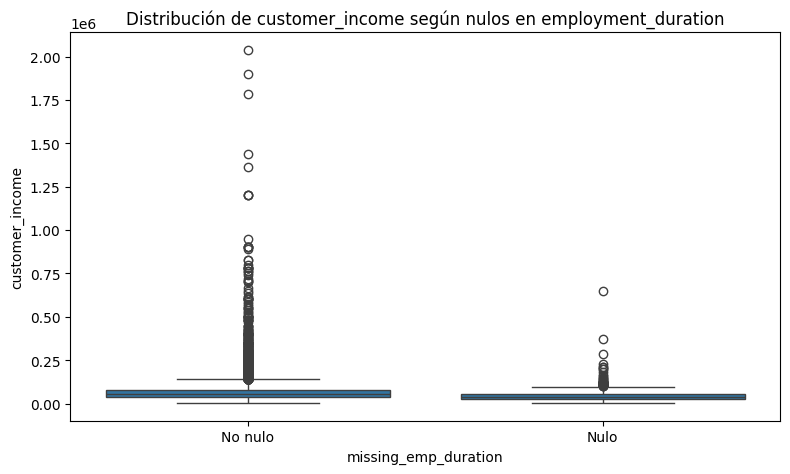

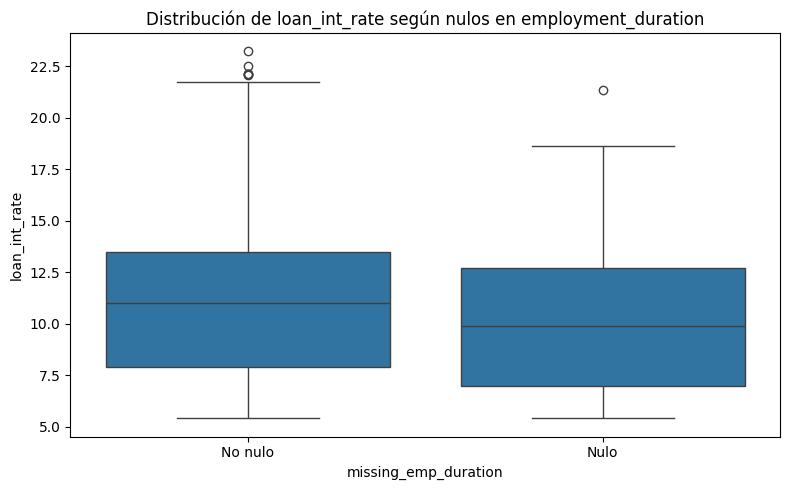

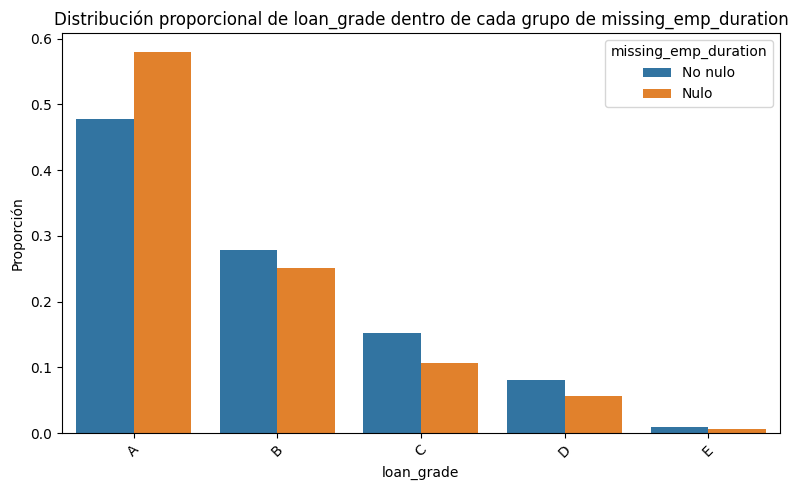

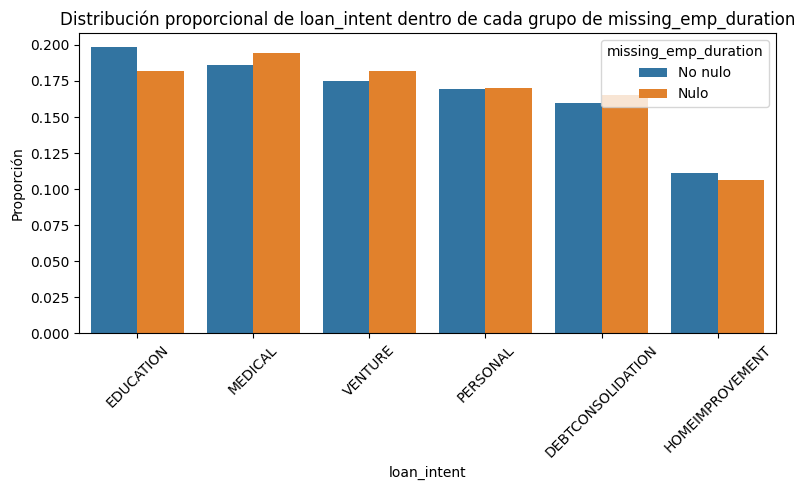

In [ ]:
loan_2['missing_emp_duration'] = loan_2['employment_duration'].isna().map({True: 'Nulo', False: 'No nulo'})

# Variables que queremos analizar
variables = ['customer_age', 'customer_income', 'loan_int_rate', 'loan_grade', 'loan_intent']

for var in variables:
    plt.figure(figsize=(8, 5))

    if loan_2[var].dtype in ['int64', 'float64', 'Int64']:
        # Variables numéricas: boxplot
        sns.boxplot(data=loan_2, x='missing_emp_duration', y=var)
        plt.title(f"Distribución de {var} según nulos en employment_duration")

    else:
        # Variables categóricas: proporciones por grupo de Nulo / No nulo
        prop_df = (
            loan_2.groupby('missing_emp_duration')[var]
            .value_counts(normalize=True)
            .rename('proportion')
            .reset_index()
        )

        # Ordenar loan_grade si aplica
        if var == 'loan_grade':
            order = ['A', 'B', 'C', 'D', 'E']
            prop_df[var] = pd.Categorical(prop_df[var], categories=order, ordered=True)
            prop_df = prop_df.sort_values(var)

        # Gráfico
        sns.barplot(data=prop_df, x=var, y='proportion', hue='missing_emp_duration')
        plt.title(f"Distribución proporcional de {var} dentro de cada grupo de missing_emp_duration")
        plt.ylabel("Proporción")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# **LIMPIEZA DE LA BASE**
Realizamos la limpieza en función de lo que hemos ido viendo a lo largo del EDA

In [ ]:
#Creamos una copia de los datos para limpiar la base
loan_mod = loan.copy()
loan_mod.head()

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
0,1,22,59000,RENT,123,PERSONAL,C,35000.0,16.02,10,True,3,True
1,2,21,9600,OWN,5,EDUCATION,A,1000.0,11.14,1,<NA>,2,False
2,3,25,9600,MORTGAGE,1,MEDICAL,B,5500.0,12.87,5,False,3,True
3,4,23,65500,RENT,4,MEDICAL,B,35000.0,15.23,10,False,2,True
4,5,24,54400,RENT,8,MEDICAL,B,35000.0,14.27,10,True,4,True


In [ ]:
#Eliminamos los 6 registros duplicados.
loan_mod.drop_duplicates(inplace=True)

In [ ]:
# Vemos las columnas que tiene_loan_mod

loan_mod.columns

Index(['customer_id', 'customer_age', 'customer_income', 'home_ownership',
       'employment_duration', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'term_years', 'historical_default', 'cred_hist_length',
       'Current_loan_status'],
      dtype='object')

In [ ]:
#Eliminamos las columnas de customer_id, missing_emp_duration y missing_hist_default. La primera no nos sirve para la predicción y la segunda se creo para el EDA.
loan_mod.drop(columns=['customer_id'], inplace=True)
loan_mod.head()

,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
0,22,59000,RENT,123,PERSONAL,C,35000.0,16.02,10,True,3,True
1,21,9600,OWN,5,EDUCATION,A,1000.0,11.14,1,<NA>,2,False
2,25,9600,MORTGAGE,1,MEDICAL,B,5500.0,12.87,5,False,3,True
3,23,65500,RENT,4,MEDICAL,B,35000.0,15.23,10,False,2,True
4,24,54400,RENT,8,MEDICAL,B,35000.0,14.27,10,True,4,True


In [ ]:
#Eliminación de los registros nulos en la variable employment_duration
# Filtrar el DataFrame para conservar solo los registros con dato presente
loan_mod = loan_mod[loan_mod["employment_duration"].notna()].copy()
print(f"Registros restantes: {len(loan_mod)}")
print(f"Nulos en employment_duration: {loan_mod['employment_duration'].isna().sum()}")

Registros restantes: 31691
Nulos en employment_duration: 0


In [ ]:
# Eliminar registros con customer_age > 100 y menores a 18
loan_mod = loan_mod[loan_mod["customer_age"] >= 18]
loan_mod = loan_mod[loan_mod["customer_age"] <= 100]

# Eliminar registros con employment_duration > 45
loan_mod = loan_mod[loan_mod["employment_duration"] <= 45]

# Confirmar cantidad final de registros
print(f"Cantidad final de registros limpios: {len(loan_mod)}")

#Se eliminan dos registros de employment duration de 123 años y 5 de customer age de 3 de 144 y 2 de 123.

Cantidad final de registros limpios: 31681


In [ ]:
#LLenamos los vacios en historical default a Not Available para no perder esta información.
loan_mod['historical_default'] = loan_mod['historical_default'].astype(str).replace({'<NA>': 'No Register', '': 'No Register'})

In [ ]:
#Validamos cuantos registros tienen valores nulos
loan_mod.isnull().sum()
loan_mod.head()

,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
1,21,9600,OWN,5,EDUCATION,A,1000.0,11.14,1,No Register,2,False
2,25,9600,MORTGAGE,1,MEDICAL,B,5500.0,12.87,5,False,3,True
3,23,65500,RENT,4,MEDICAL,B,35000.0,15.23,10,False,2,True
4,24,54400,RENT,8,MEDICAL,B,35000.0,14.27,10,True,4,True
5,21,9900,OWN,2,VENTURE,A,2500.0,7.14,1,False,2,True


In [ ]:
print(loan_mod['historical_default'].unique())


['No Register' 'False' 'True']


In [ ]:
# Contar registros de cada clase en 'historical_default'
class_counts = loan_mod['historical_default'].value_counts()

# Imprimir los resultados
print(class_counts)

historical_default
No Register    20174
True            5997
False           5510
Name: count, dtype: int64


In [ ]:
loan_mod.isnull().sum()

,0
customer_age,0
customer_income,0
home_ownership,0
employment_duration,0
loan_intent,0
loan_grade,0
loan_amnt,1
loan_int_rate,3047
term_years,0
historical_default,0


### DESCARGAMOS EL FICHERO LIMPIO

In [ ]:
loan_mod.to_csv('loan_data_limpio.csv', index=False)

In [ ]:
files.download('loan_data_limpio.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>